# Example: run MultiSolSegment and validate
This examples hows how to download the weights for MultiSolSegment, run it on an image to segment crack, dark and busbar masks. Then use pvimage to look at crack count and parameters

In [1]:
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from pvcracks.utils import viz_functions, train_functions

import requests

from pvimage import features


project_root = Path.cwd().parents[1]
os.chdir(project_root)  # now cwd is .../pvcracks

In [2]:
project_root

PosixPath('/Users/ojas/Desktop/saj/SANDIA/pvcracks_paper_revise')

In [3]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

## Step 1: Download Model

DOI - https://doi.org/10.21948/2997859  
Direct Link - https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt

In [4]:
# if you have have already downloaded model weights, replace this with the local path
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty/checkpoints/Channeled_Combined_CWRU_LBNL_ASU_No_Empty10/epoch_19/model.pt"
# weight_path = "multisolsegment.pt"
# weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/checkpoints/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise5/epoch_6/model.pt"
weight_path = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/final_model_strict_holdout.pt"


if os.path.exists(weight_path):
    print("Weights already downloaded.")
else:
    response = requests.get(
        "https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt"
    )
    with open(weight_path, "wb") as f:
        f.write(response.content)

Weights already downloaded.


## Step 2: Download and Load Images

DOI - https://doi.org/10.21948/2587738  
Direct Link - https://datahub.duramat.org/dataset/5e7587ad-6ad1-4d6f-8432-70940a6d7ca1/resource/8f12be45-b929-4f5c-9400-84dde27b0e90/download/labeledelcells.zip

In [5]:
from zipfile import ZipFile
from io import BytesIO
import os

url = (
    "https://datahub.duramat.org/"
    "dataset/5e7587ad-6ad1-4d6f-8432-70940a6d7ca1/"
    "resource/8f12be45-b929-4f5c-9400-84dde27b0e90/"
    "download/labeledelcells.zip"
)

# out_dir = os.path.expanduser("labeled_image_data")
out_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/"

if os.path.exists(out_dir):
    print("Images already downloaded.")
else:
    os.makedirs(out_dir, exist_ok=True)

    resp = requests.get(url)
    resp.raise_for_status()

    with ZipFile(BytesIO(resp.content)) as z:
        z.extractall(path=out_dir)

Images already downloaded.


In [6]:
out_dir

'/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/'

## Step 3: Set local paths

In [7]:
# files_root = f"{out_dir}/LabeledELcells/"
files_root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_Combined_CWRU_LBNL_ASU_No_Empty_RNE_Revise/"

## Step 4: Load in everything

In [8]:
from pvcracks.utils import img_functions


category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

root = Path(files_root)

train_dataset, val_dataset = train_functions.load_dataset(root)
val_loader: DataLoader[img_functions.SolarDataset] = DataLoader(
    val_dataset, batch_size=1, shuffle=False
)
device, model = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

## Step 5: Pick image and threshold

Index is what image to run this model on.  

Threshold is what confidence % we want to code as an actual detection target, rather than just background noise.

In [9]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

threshold = 0.5  # default

## Step 6: Inference and Show

In [10]:
len(val_dataset)

468

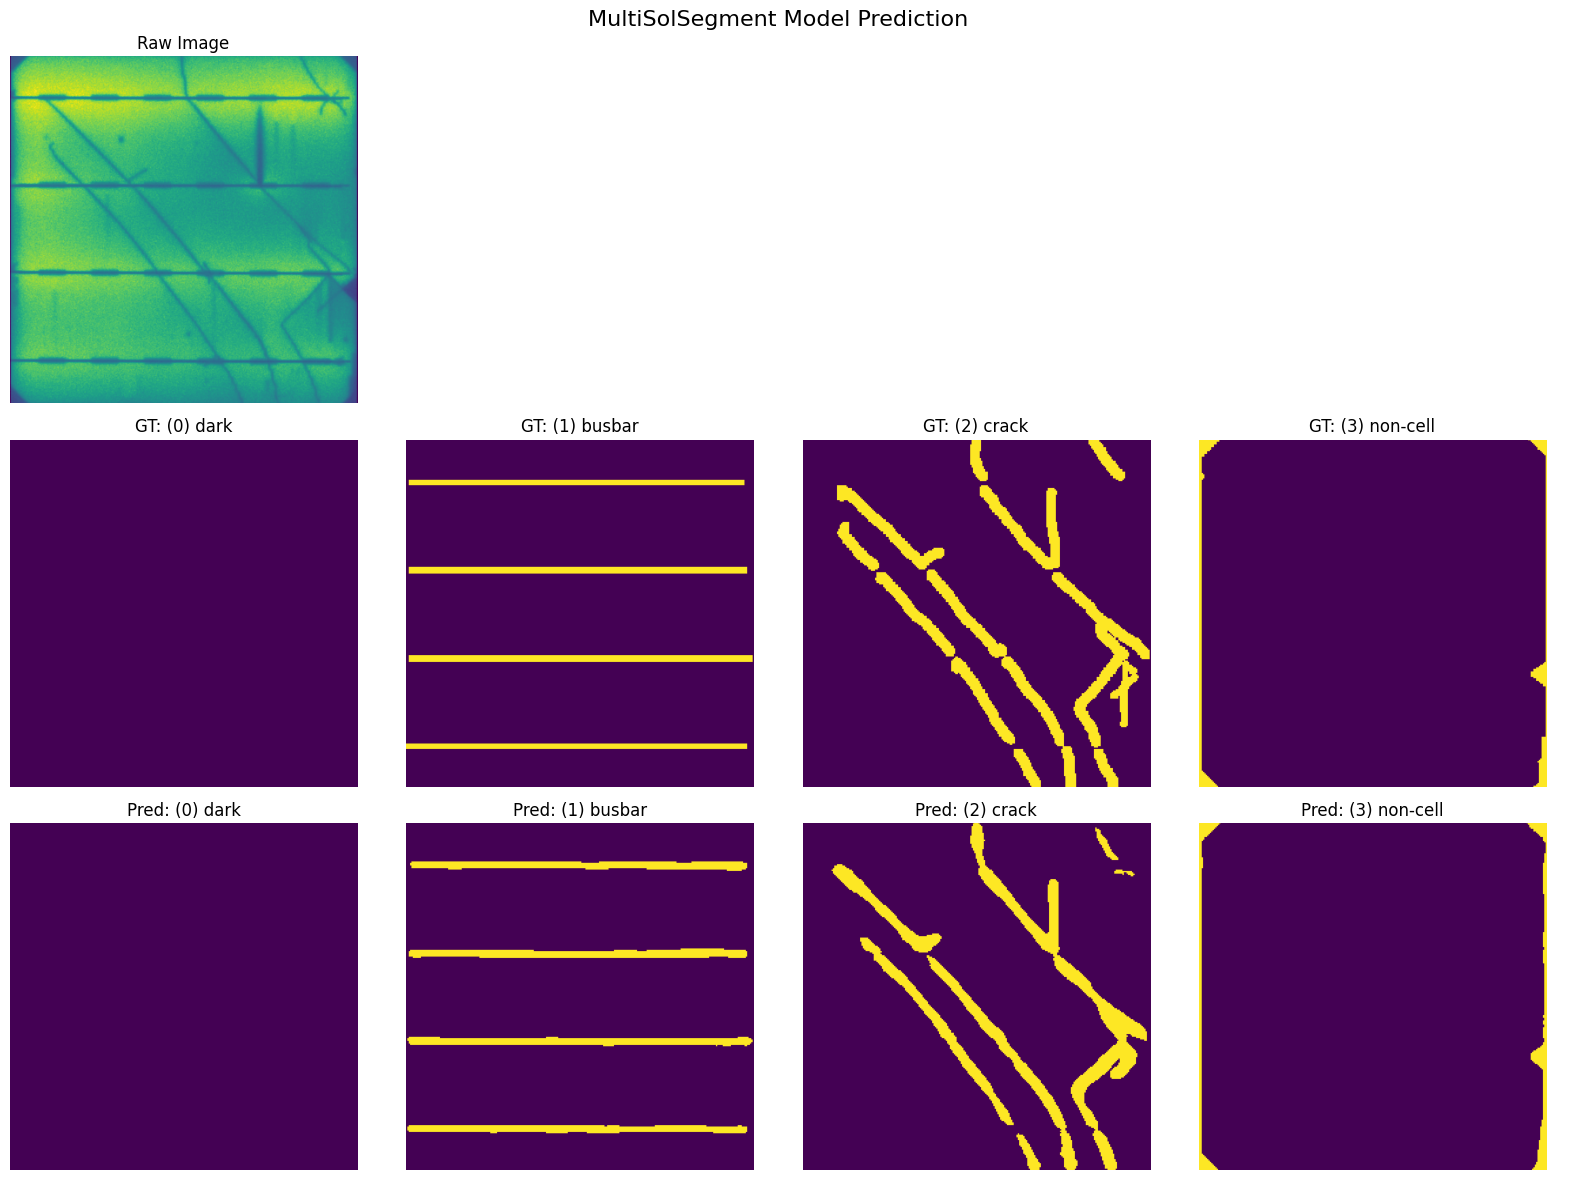

<Figure size 640x480 with 0 Axes>

In [12]:
# continuous: 22, 34, 42, 53, 59, 84, 95, 98, 99, 107, 117, 129, 138, 152, 157, 164, 167, 171, 193, 199, 246, 265, 
idx = 22

viz_functions.channeled_inference_and_show(
    val_loader,
    device,
    model,
    category_mapping,
    idx,
    threshold,
    custom_title="MultiSolSegment Model Prediction",
)
plt.savefig("mss_model_prediction.png")

Id:  22


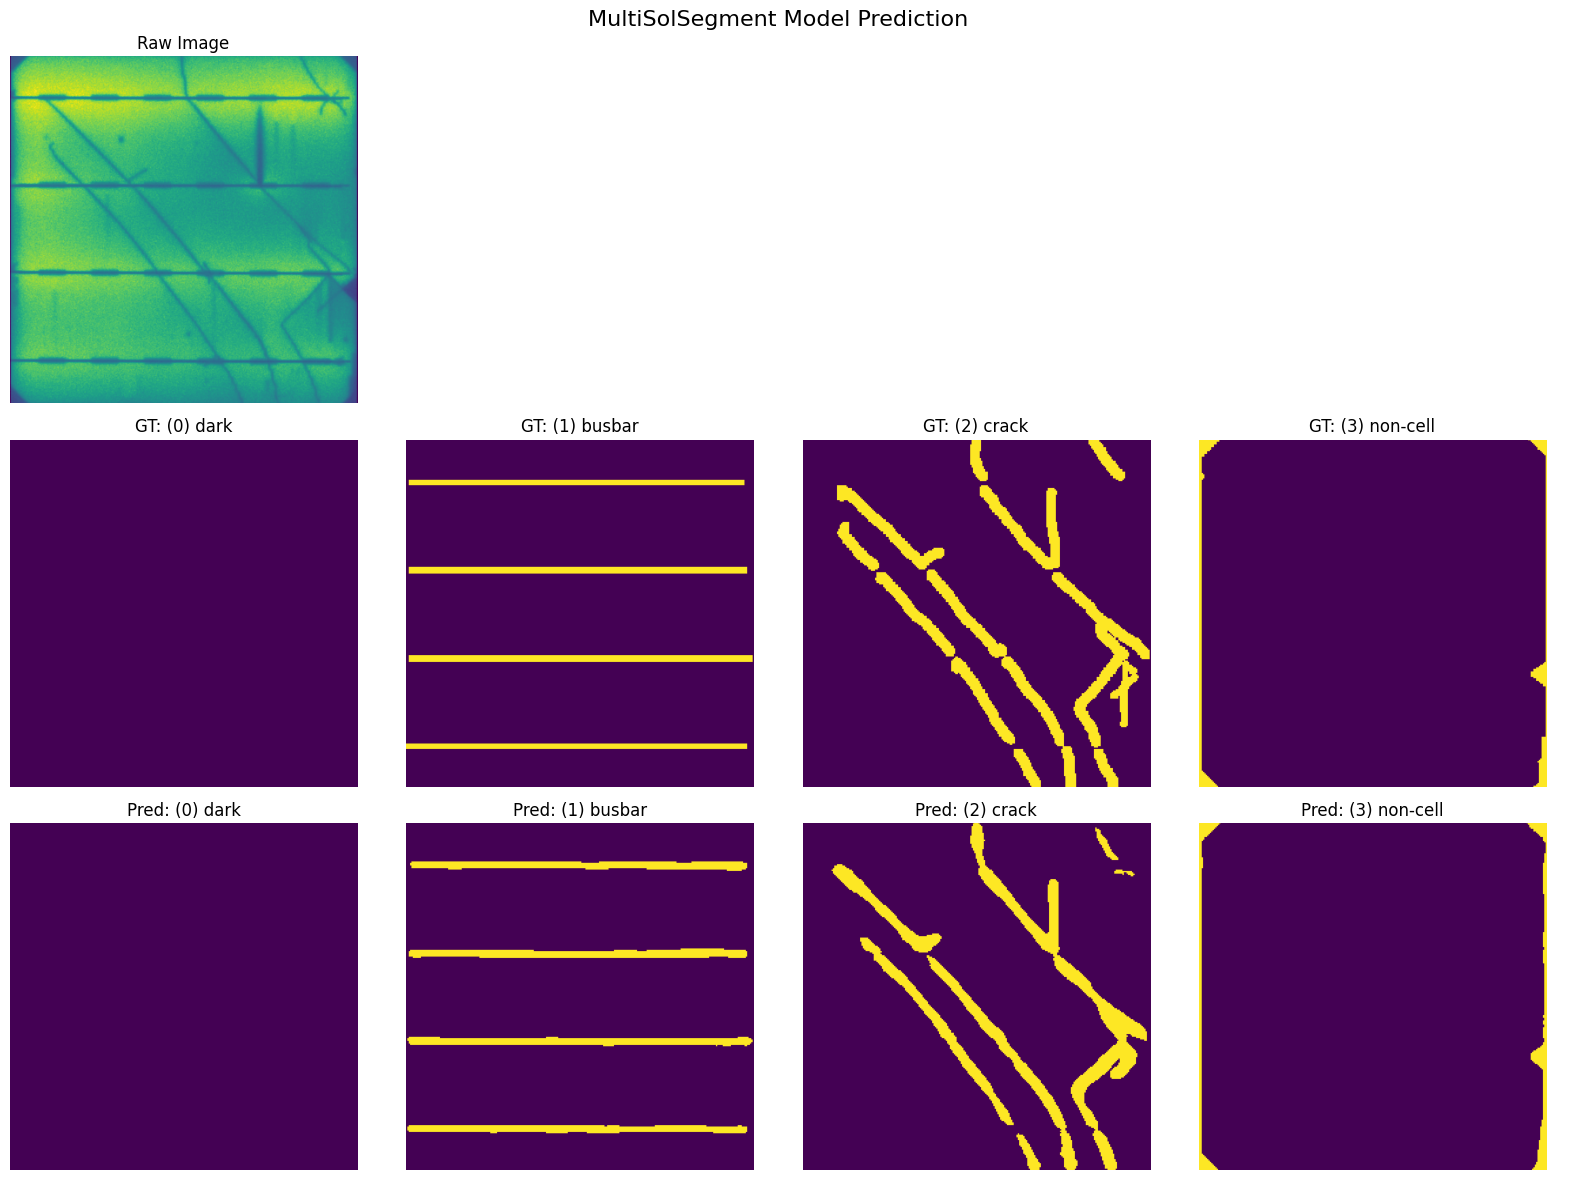

Id:  34


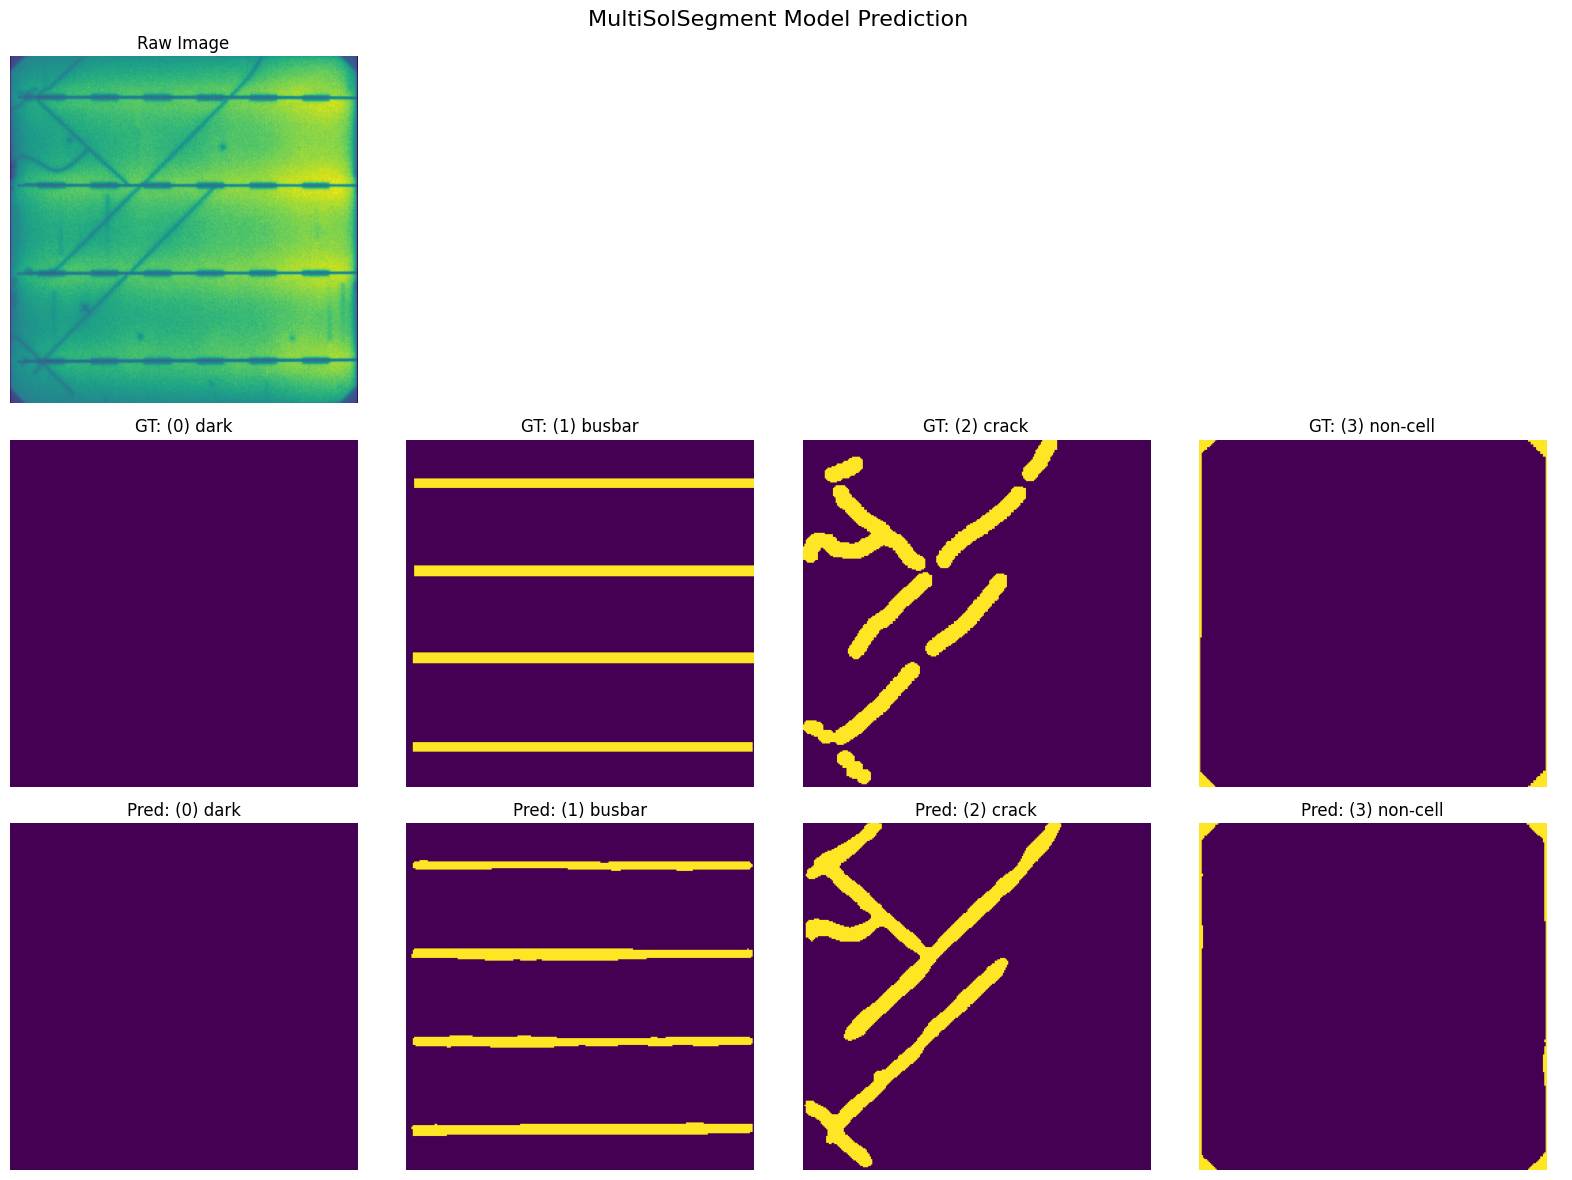

Id:  42


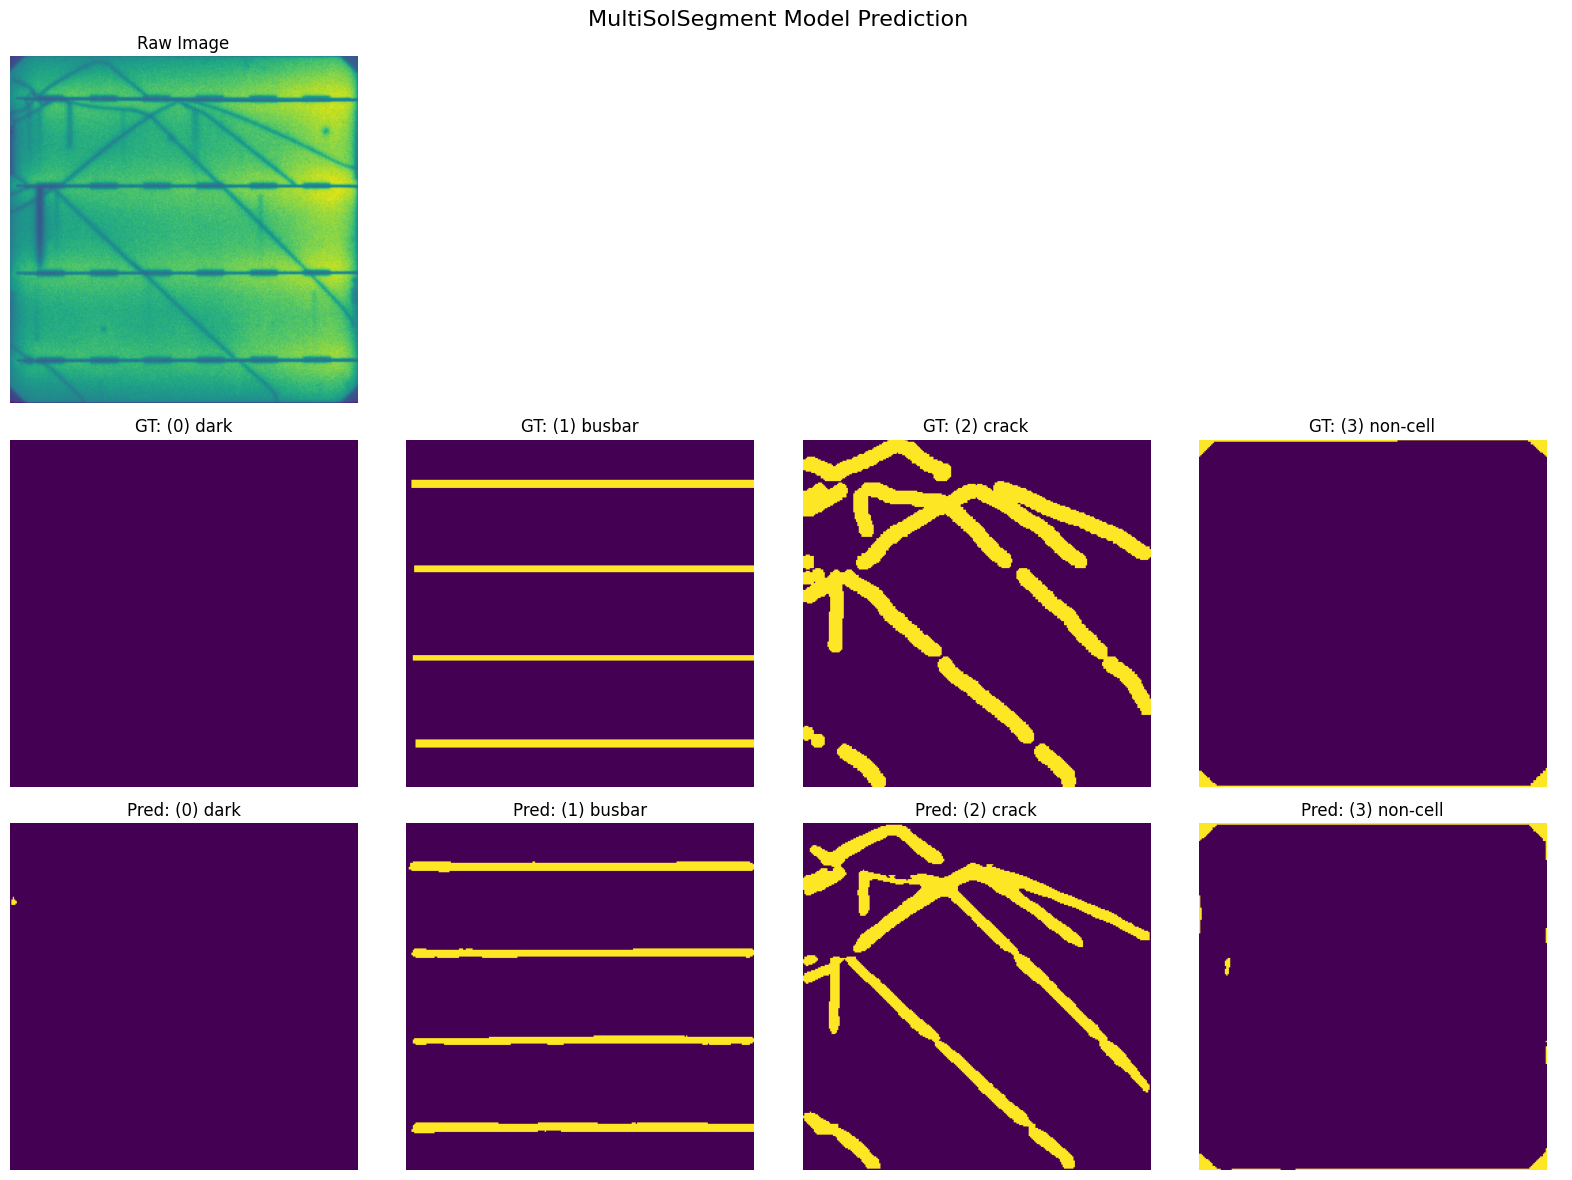

Id:  53


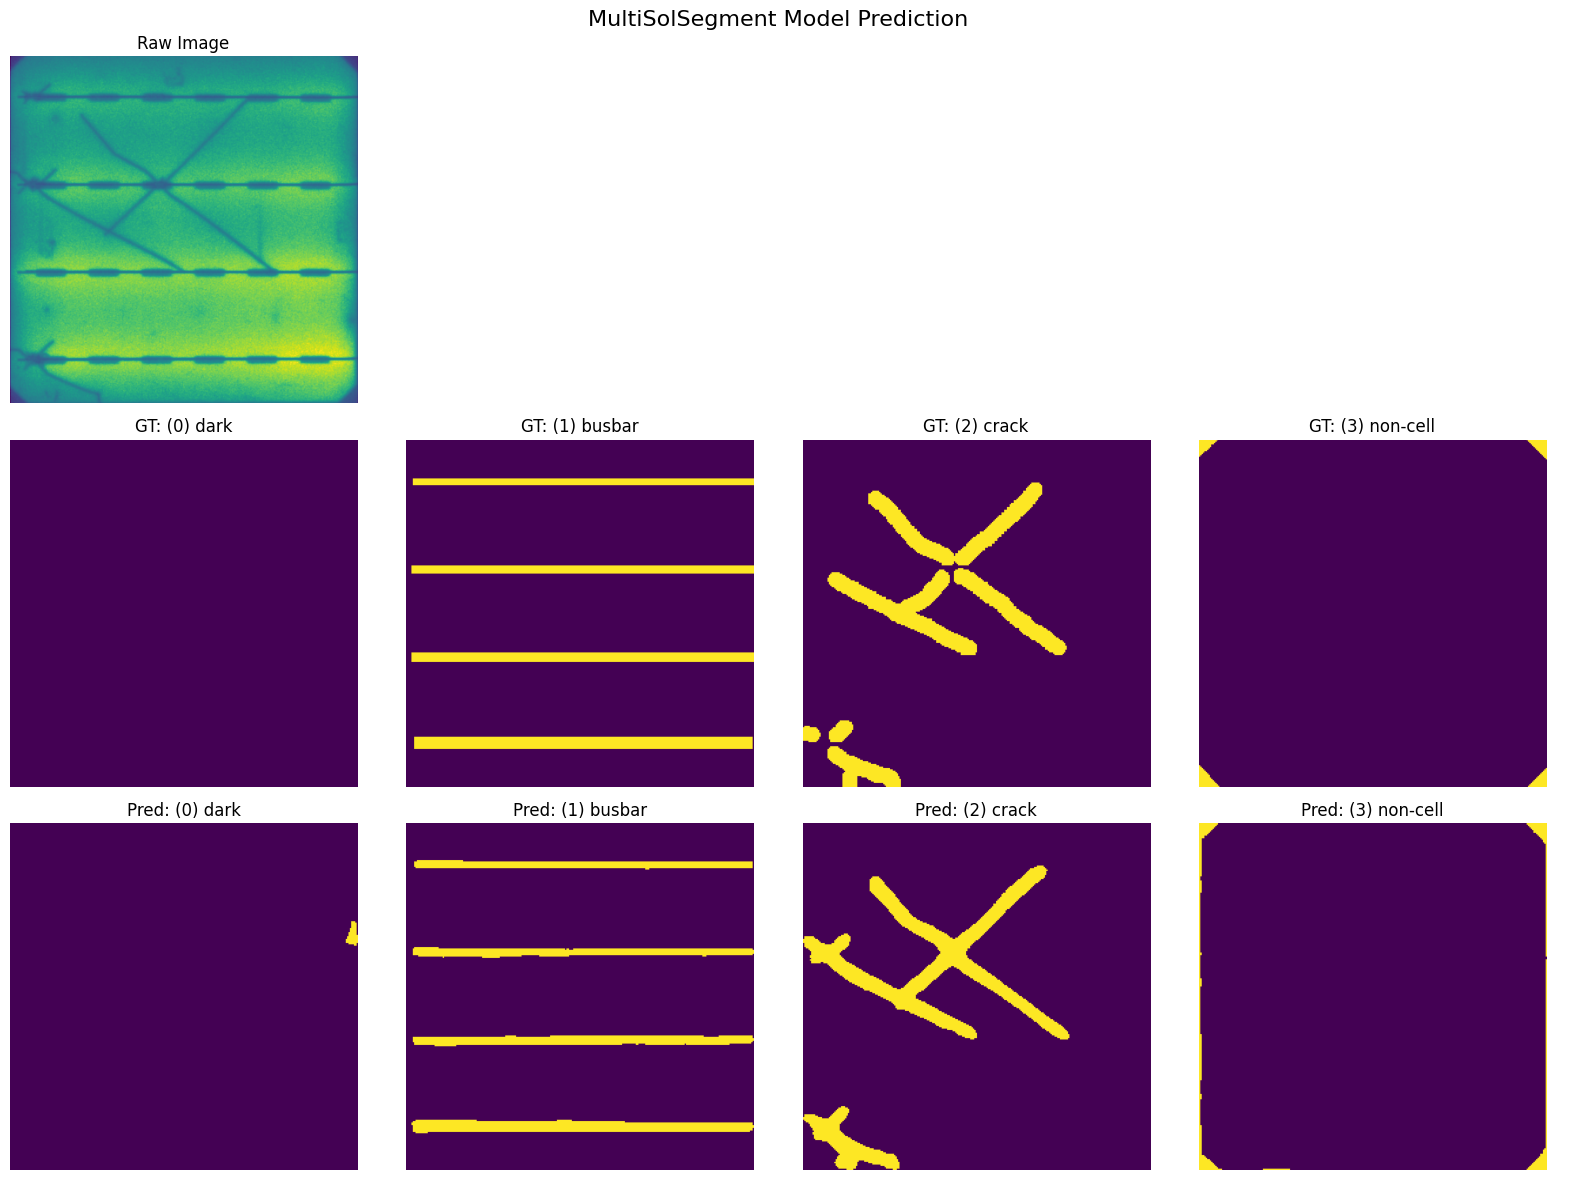

Id:  59


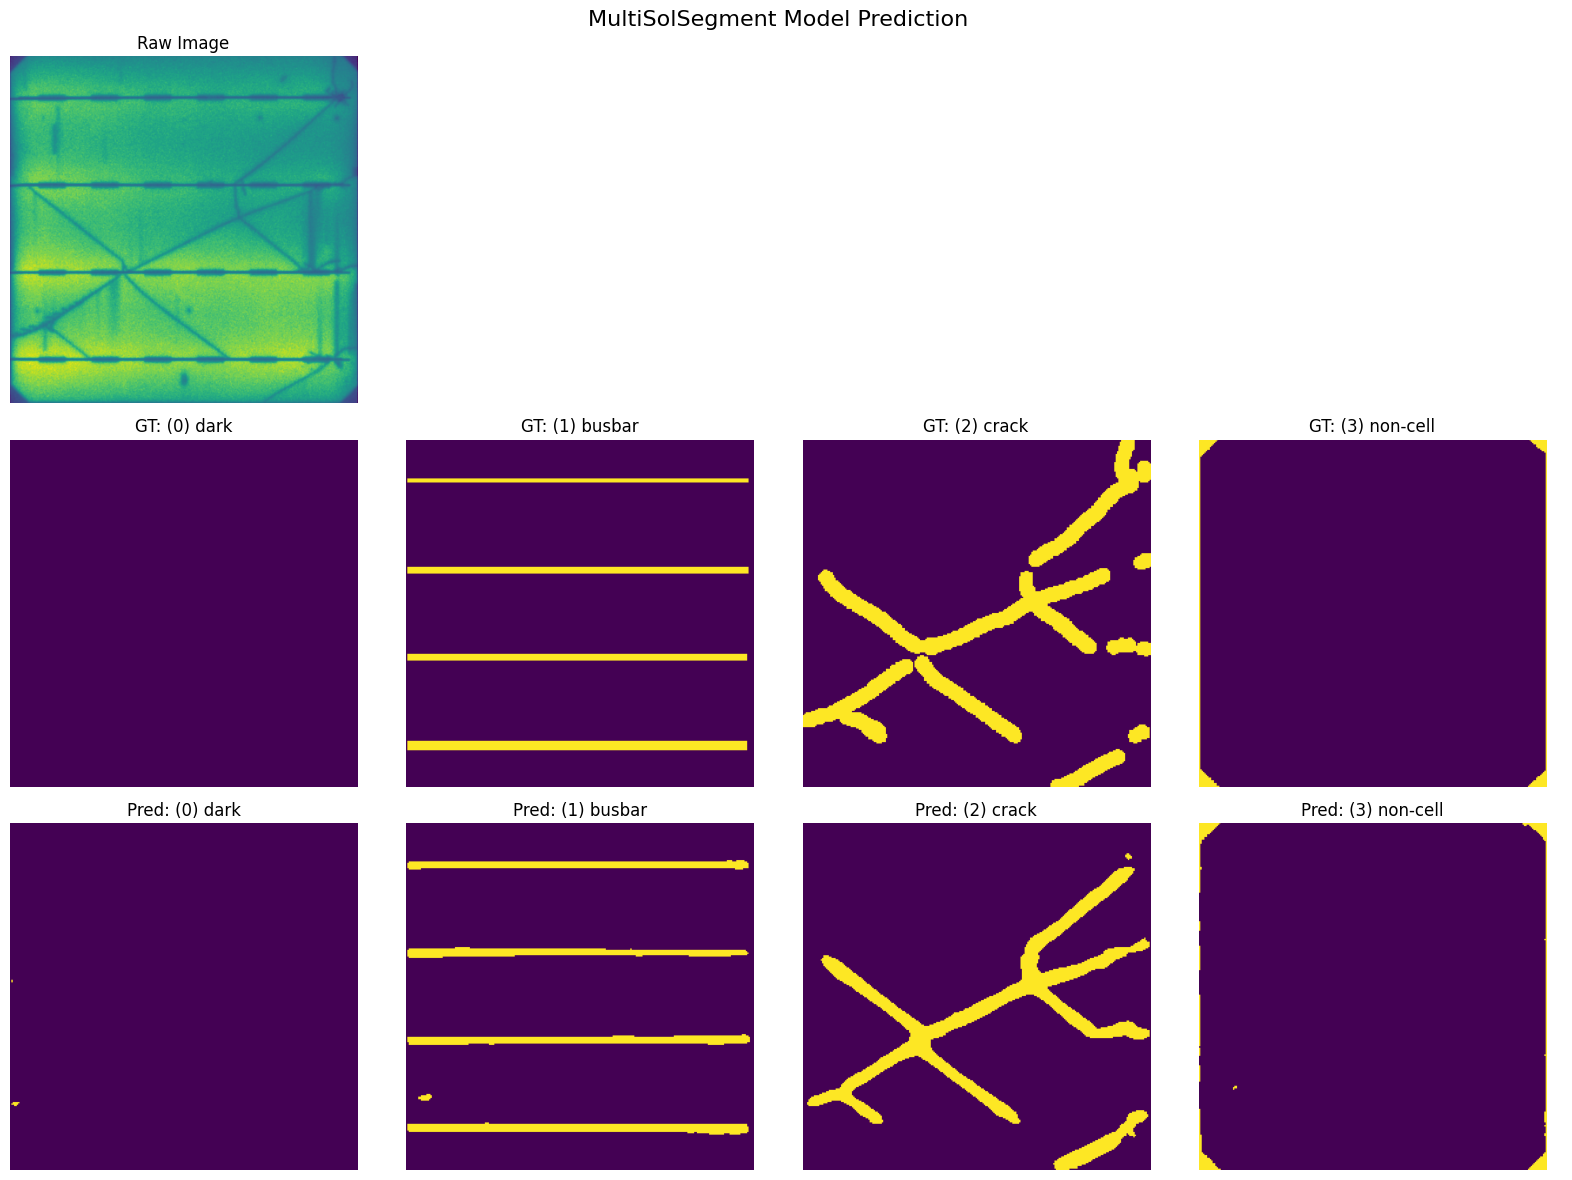

Id:  84


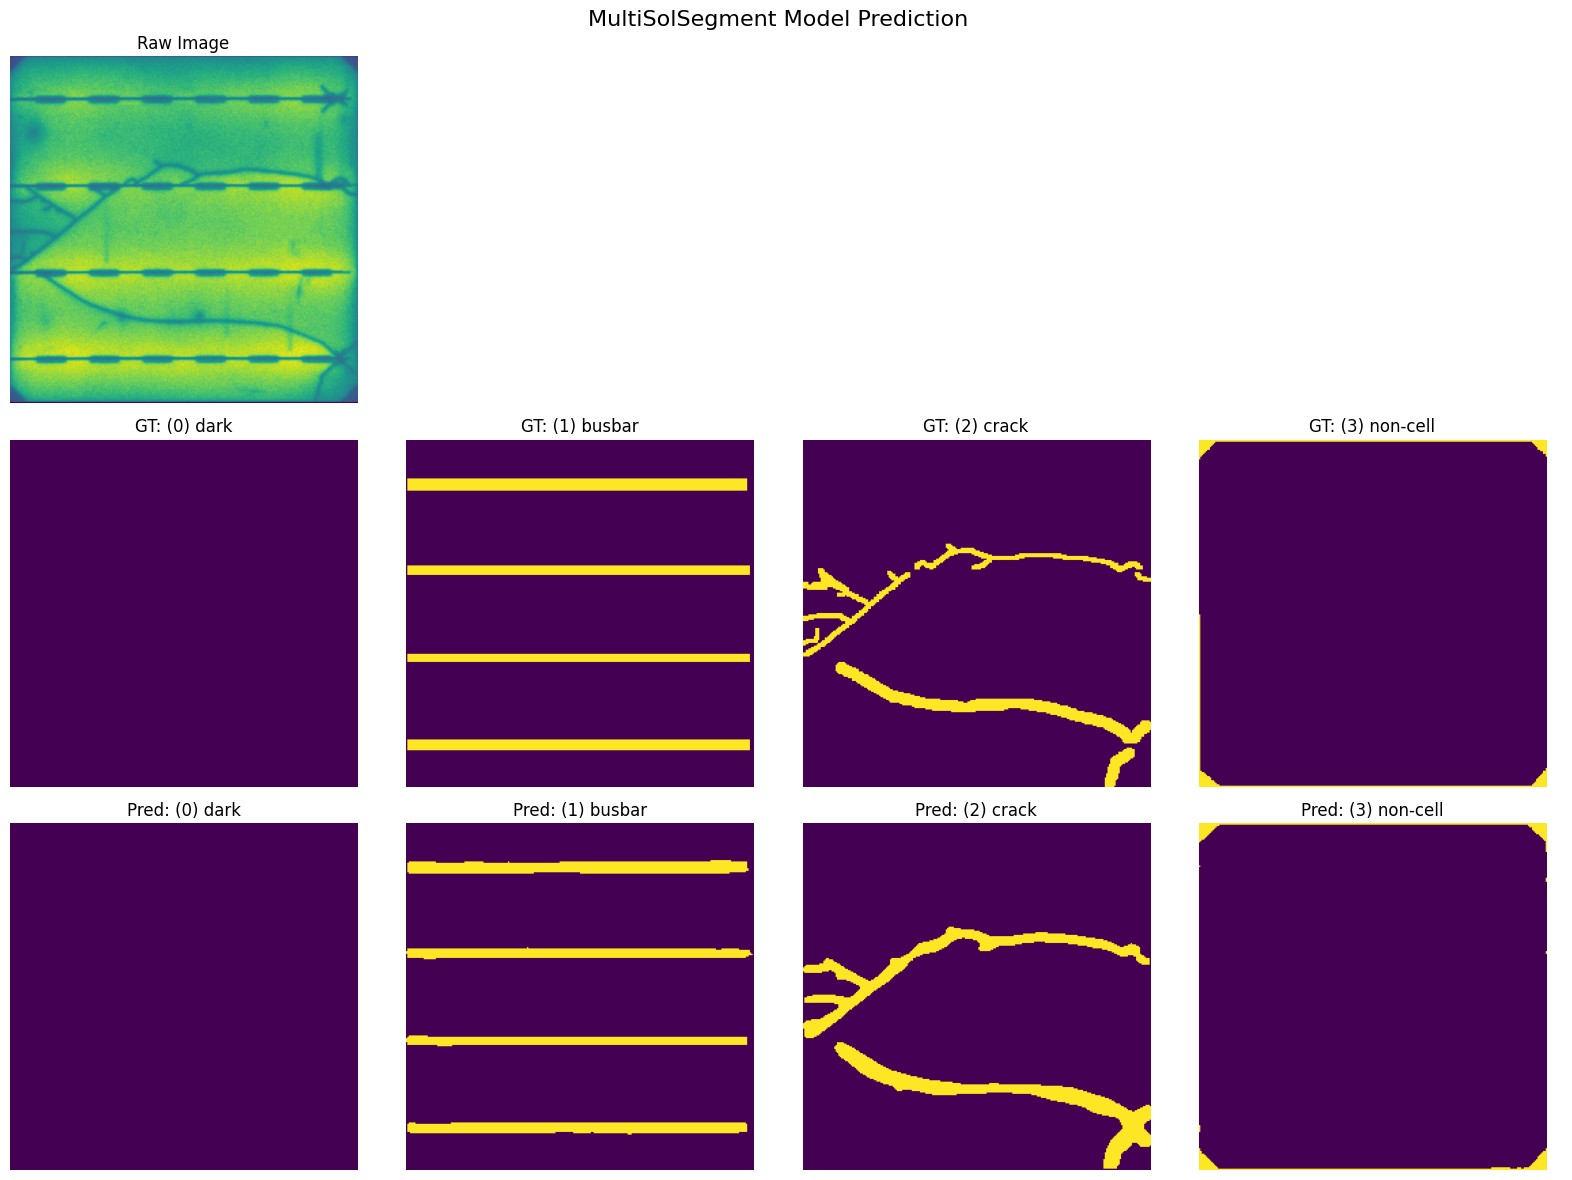

Id:  95


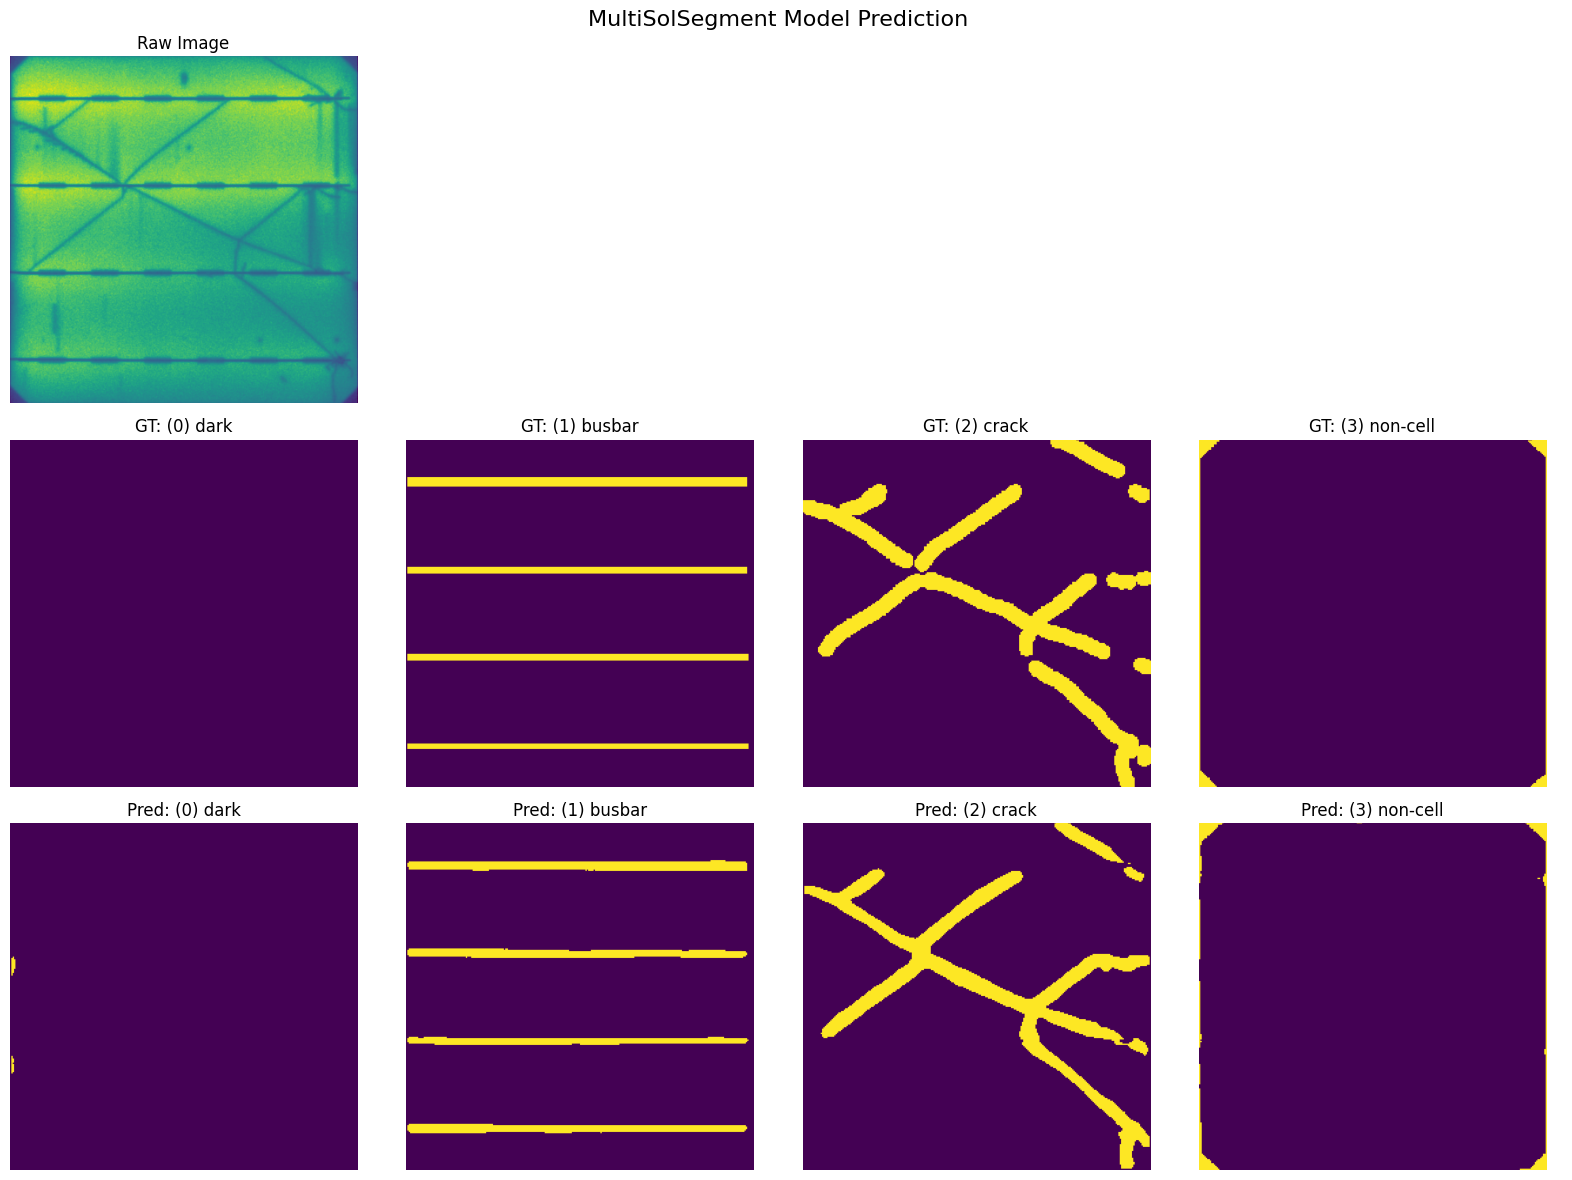

Id:  98


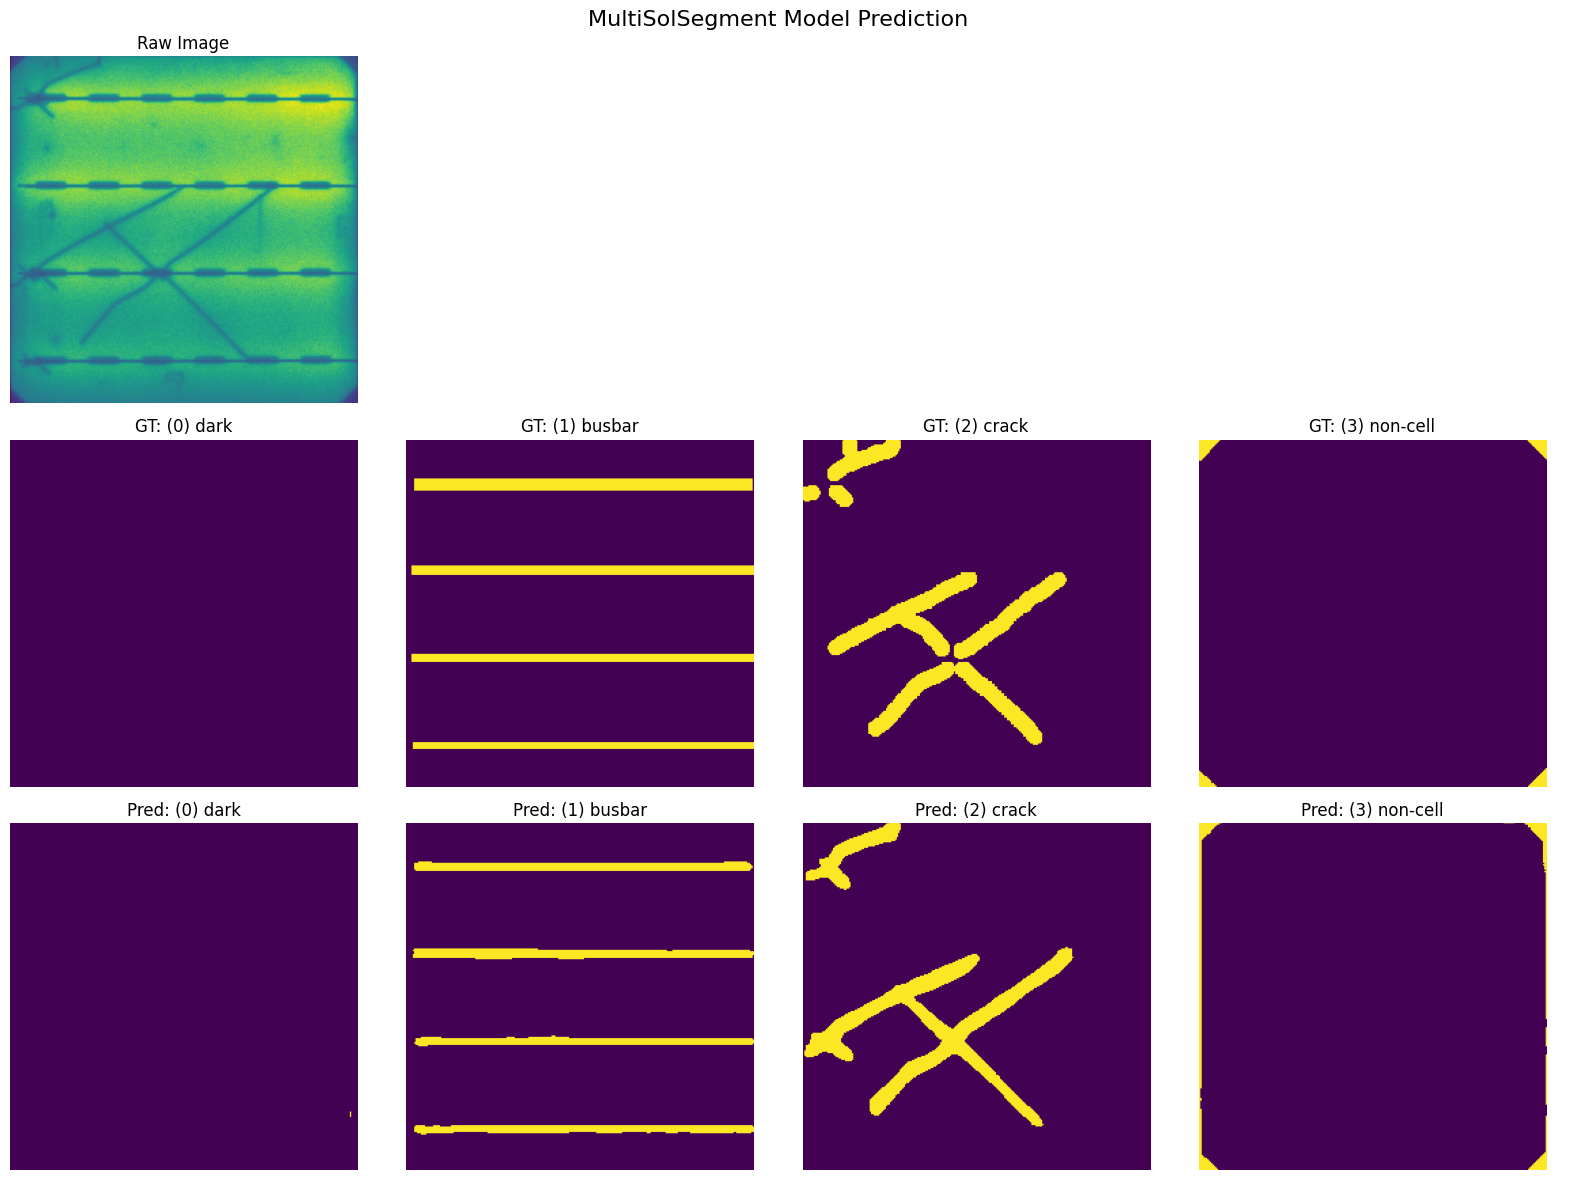

Id:  99


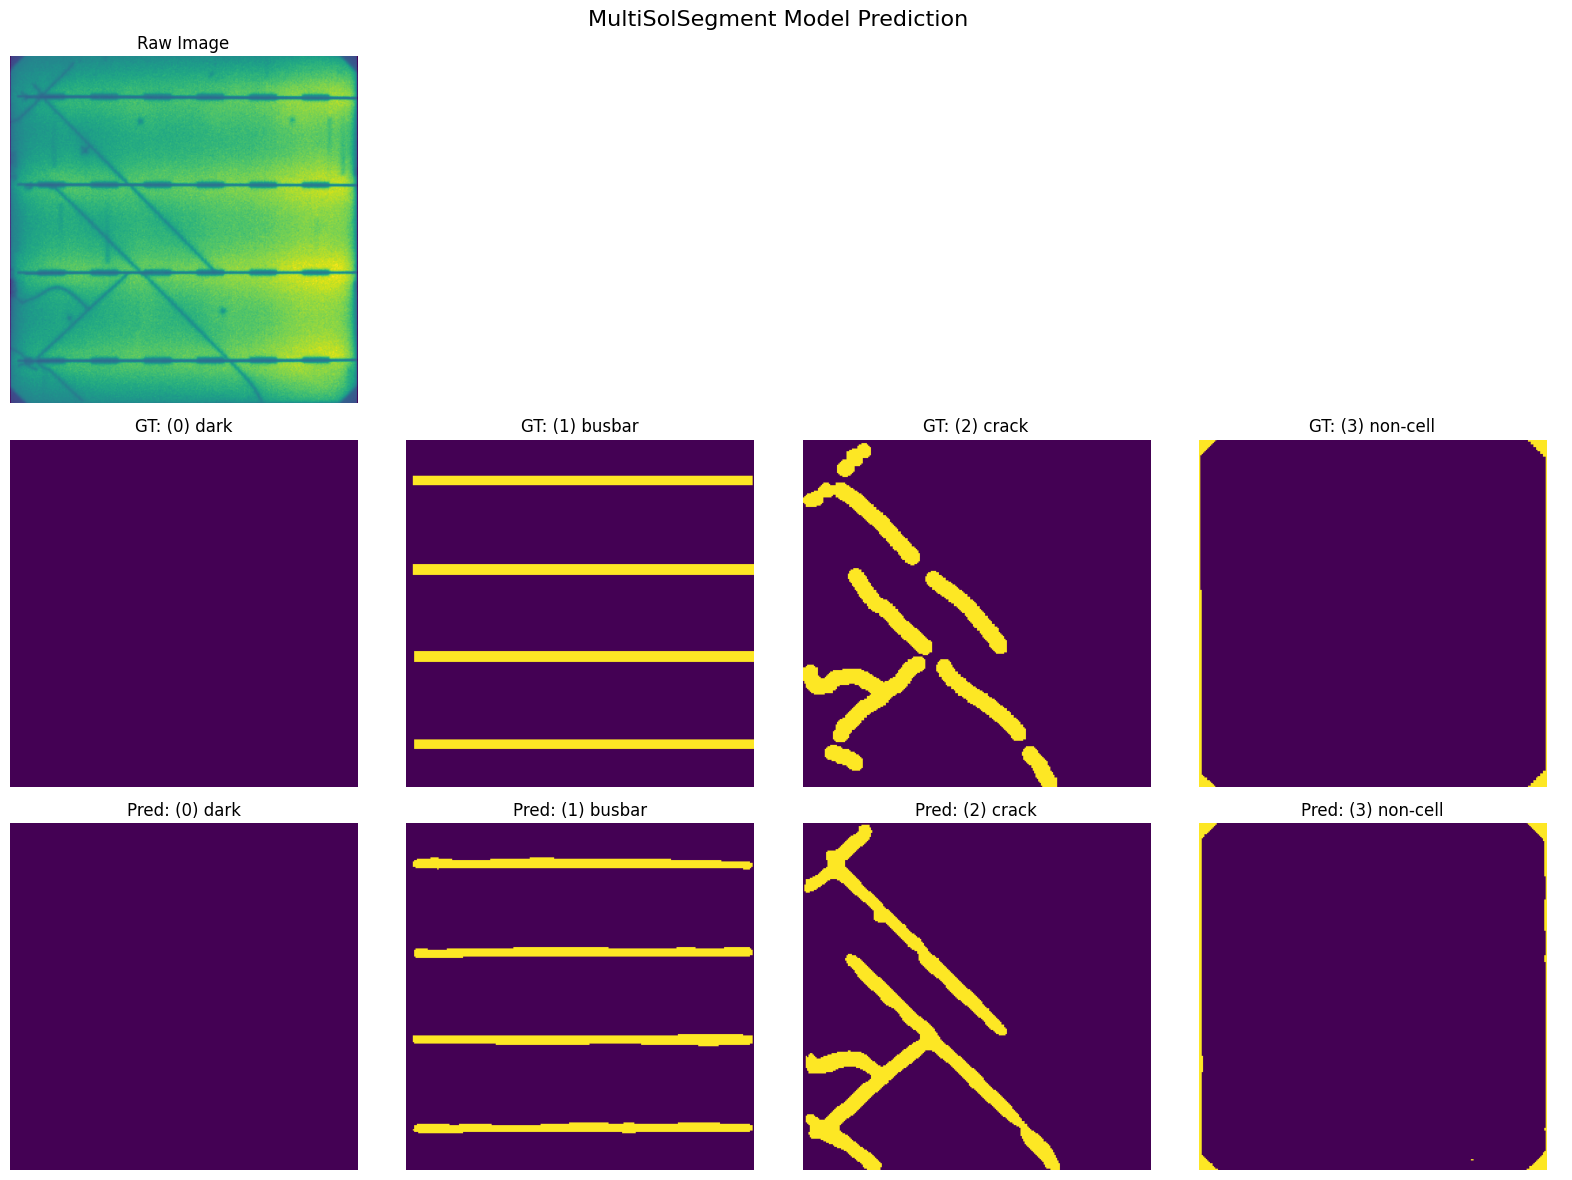

Id:  107


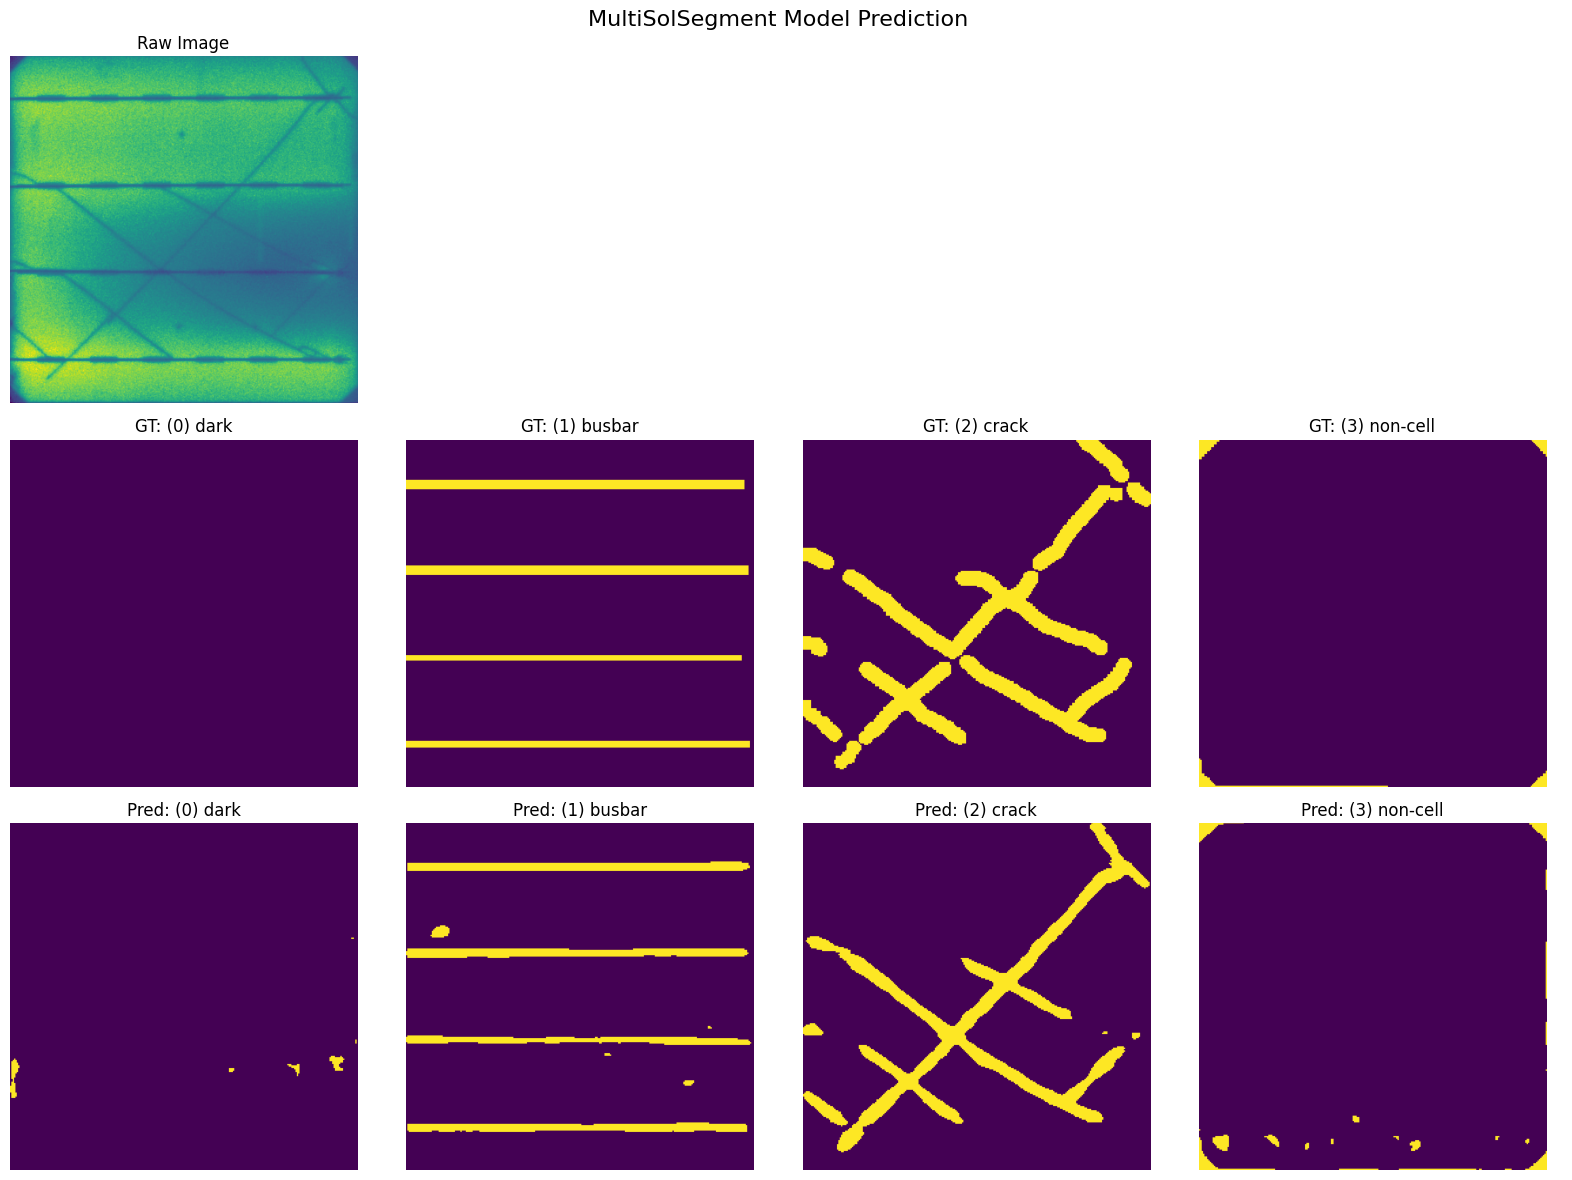

Id:  117


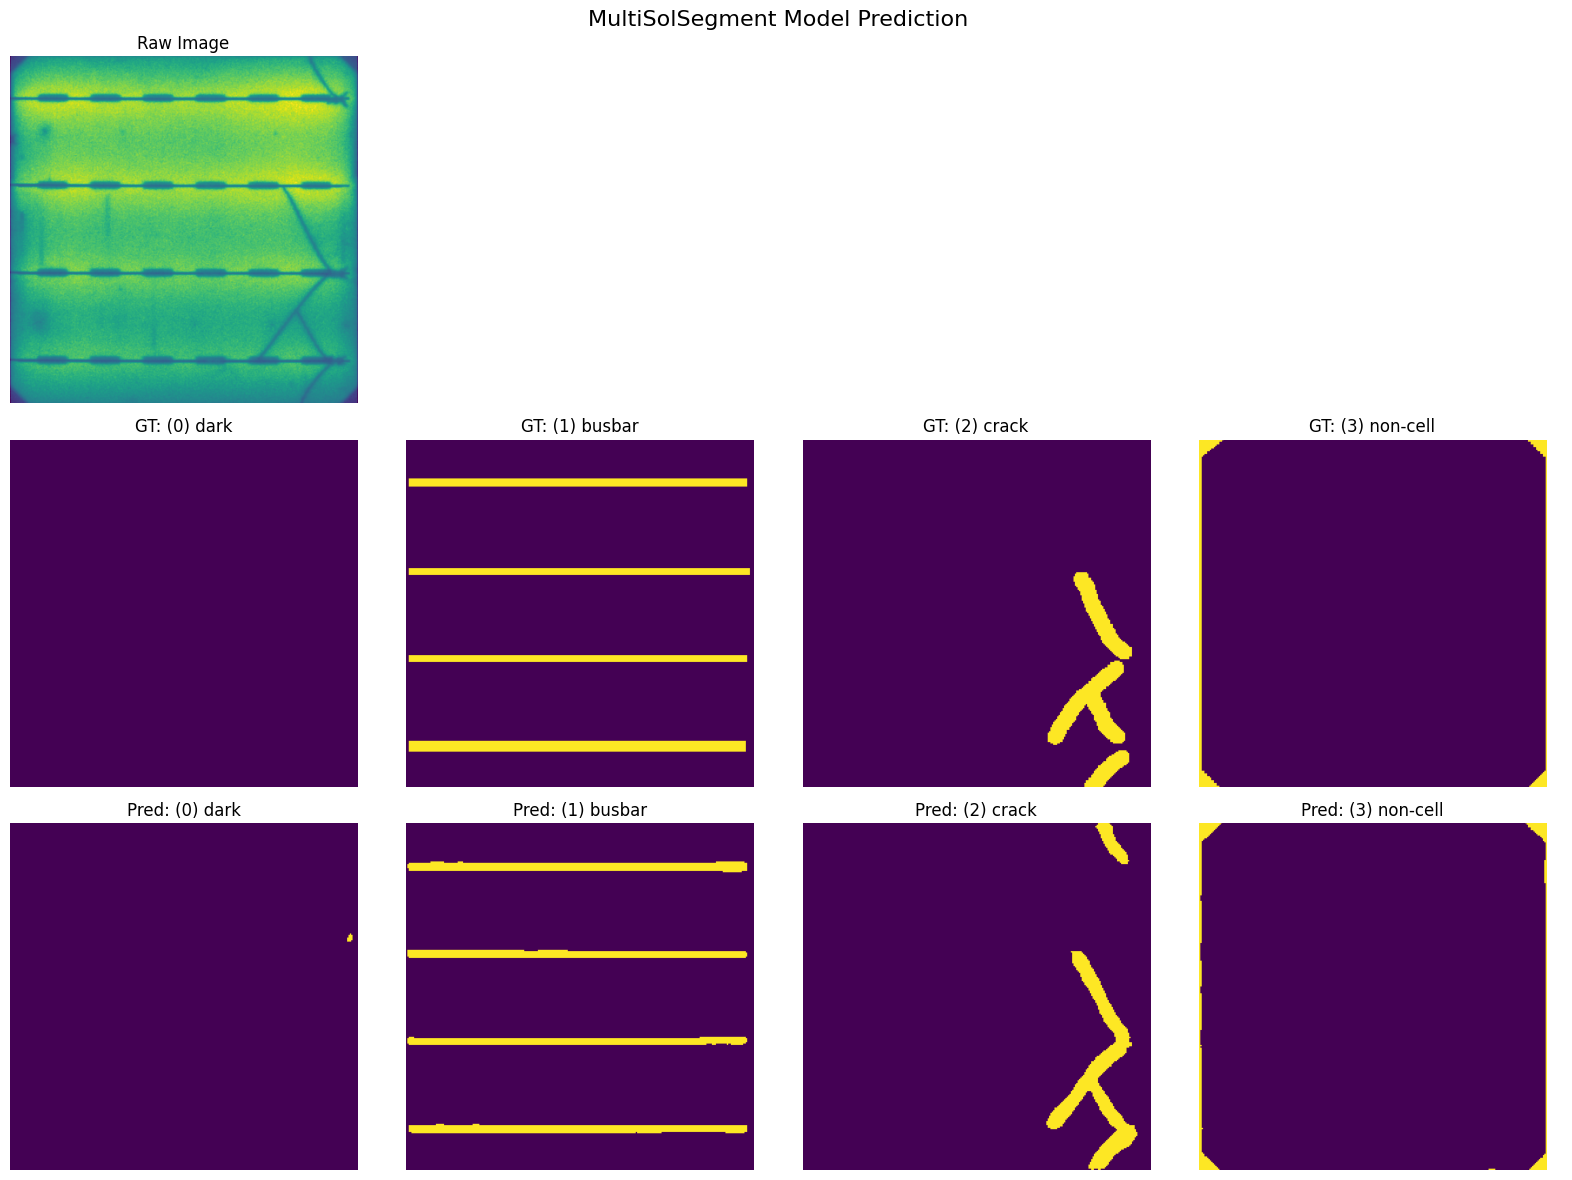

Id:  129


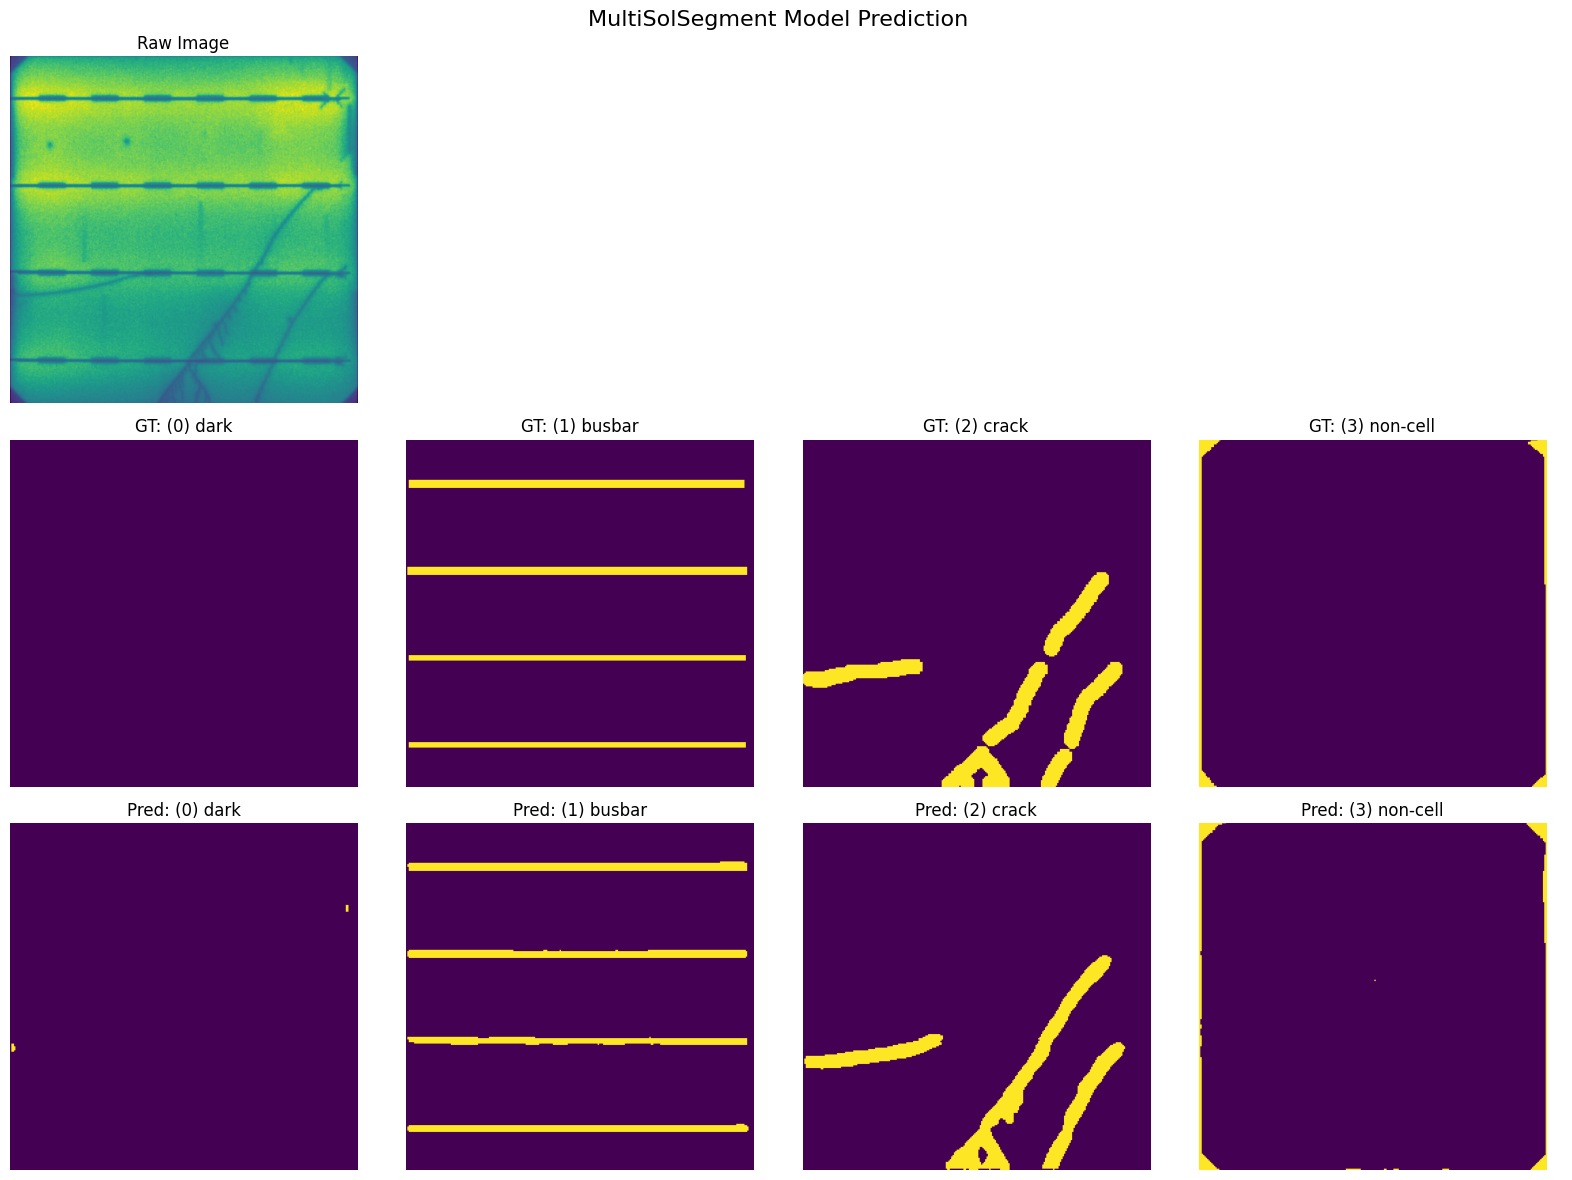

Id:  138


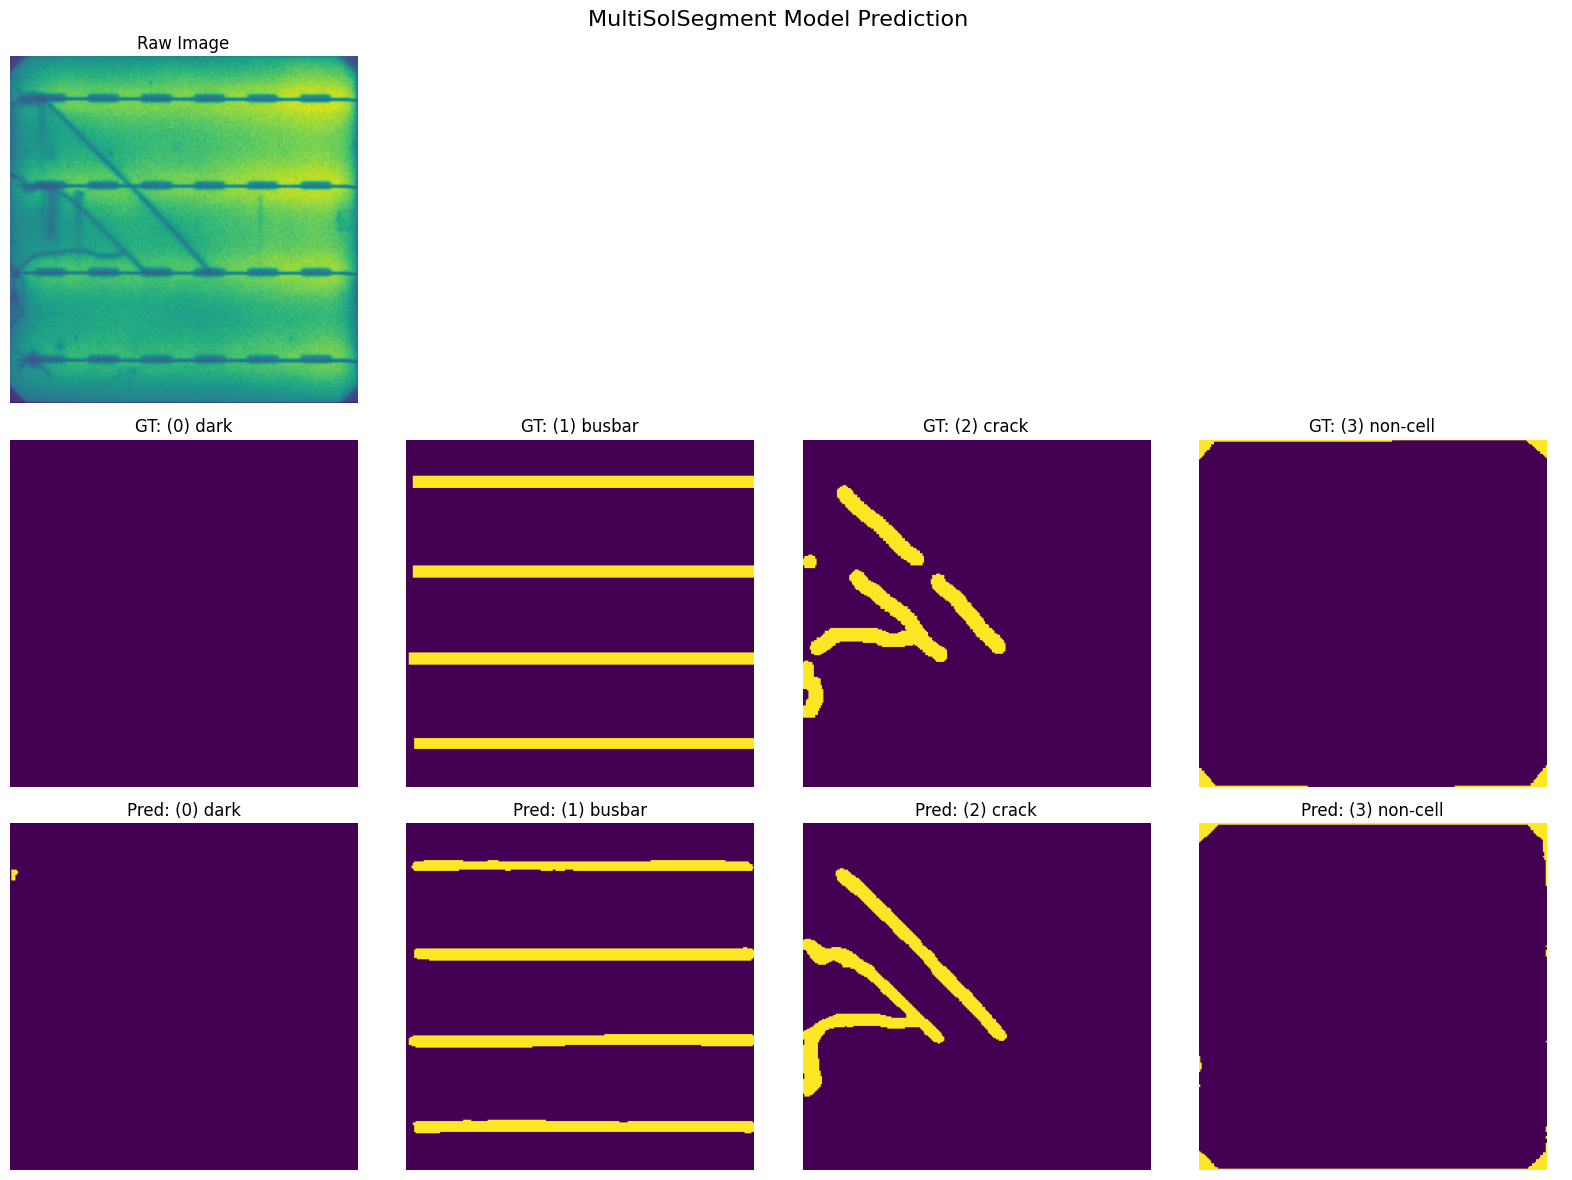

Id:  152


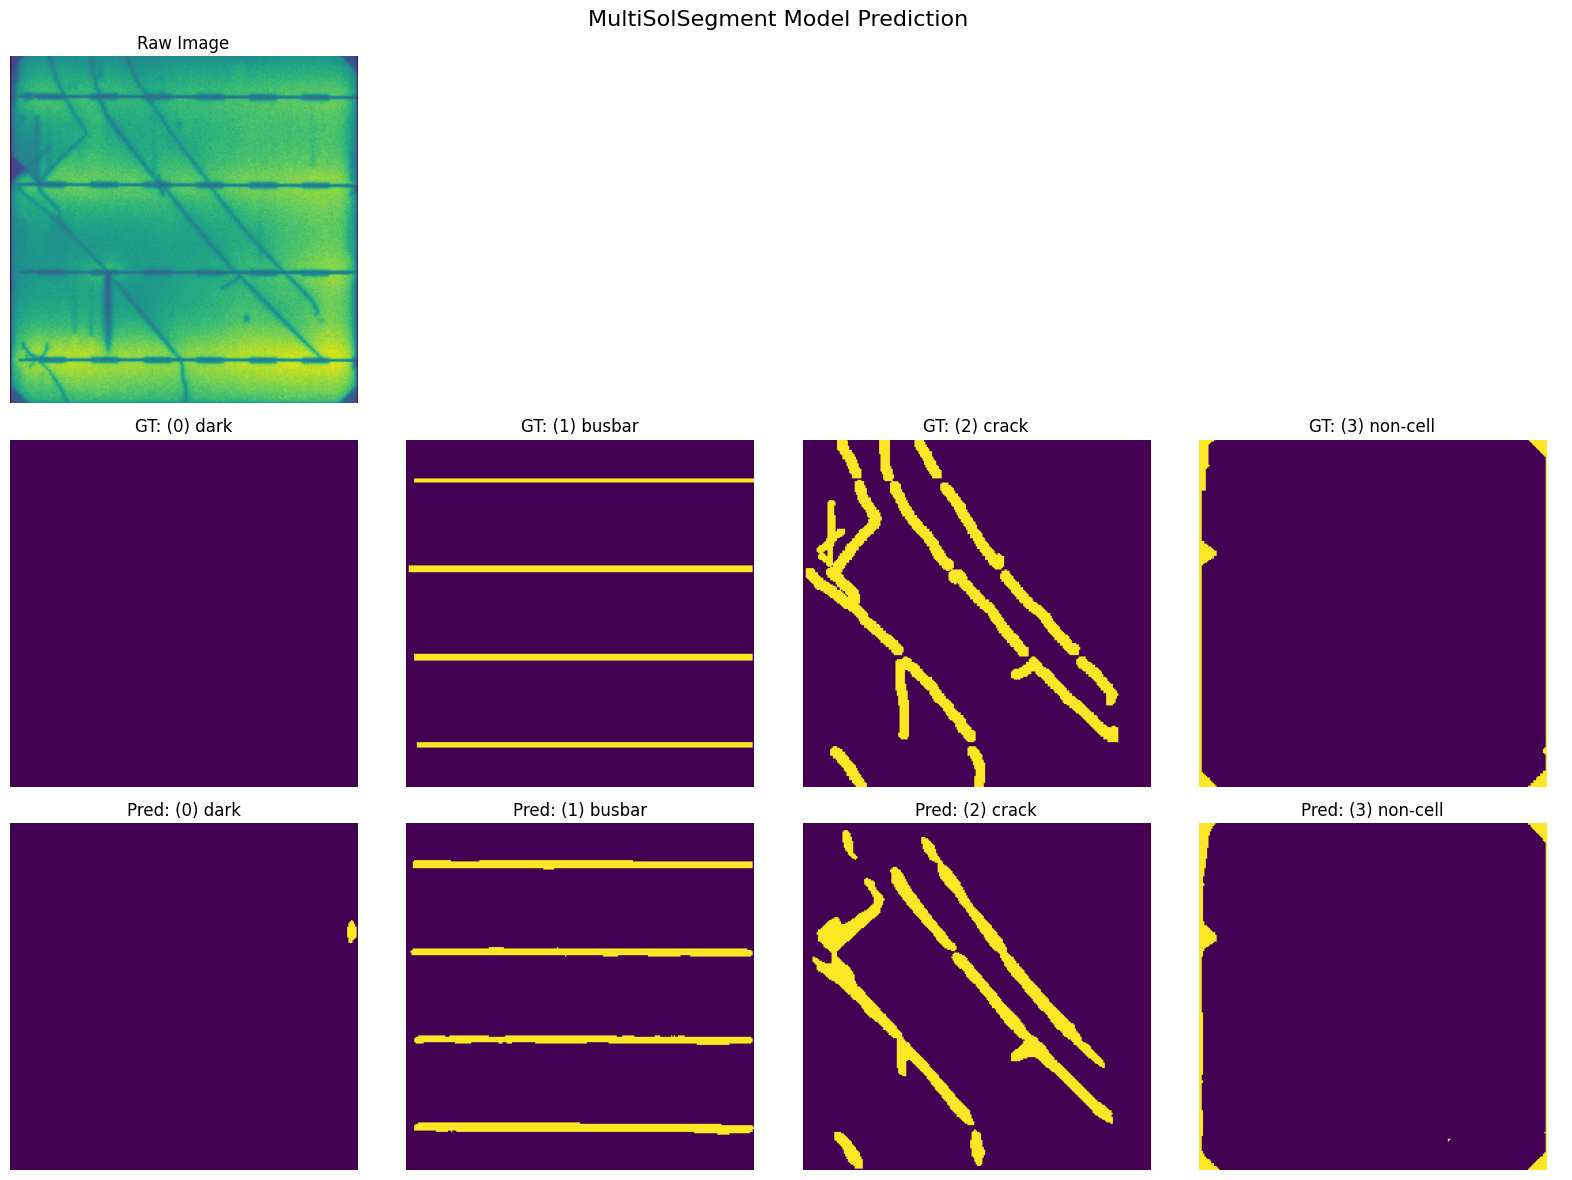

Id:  157


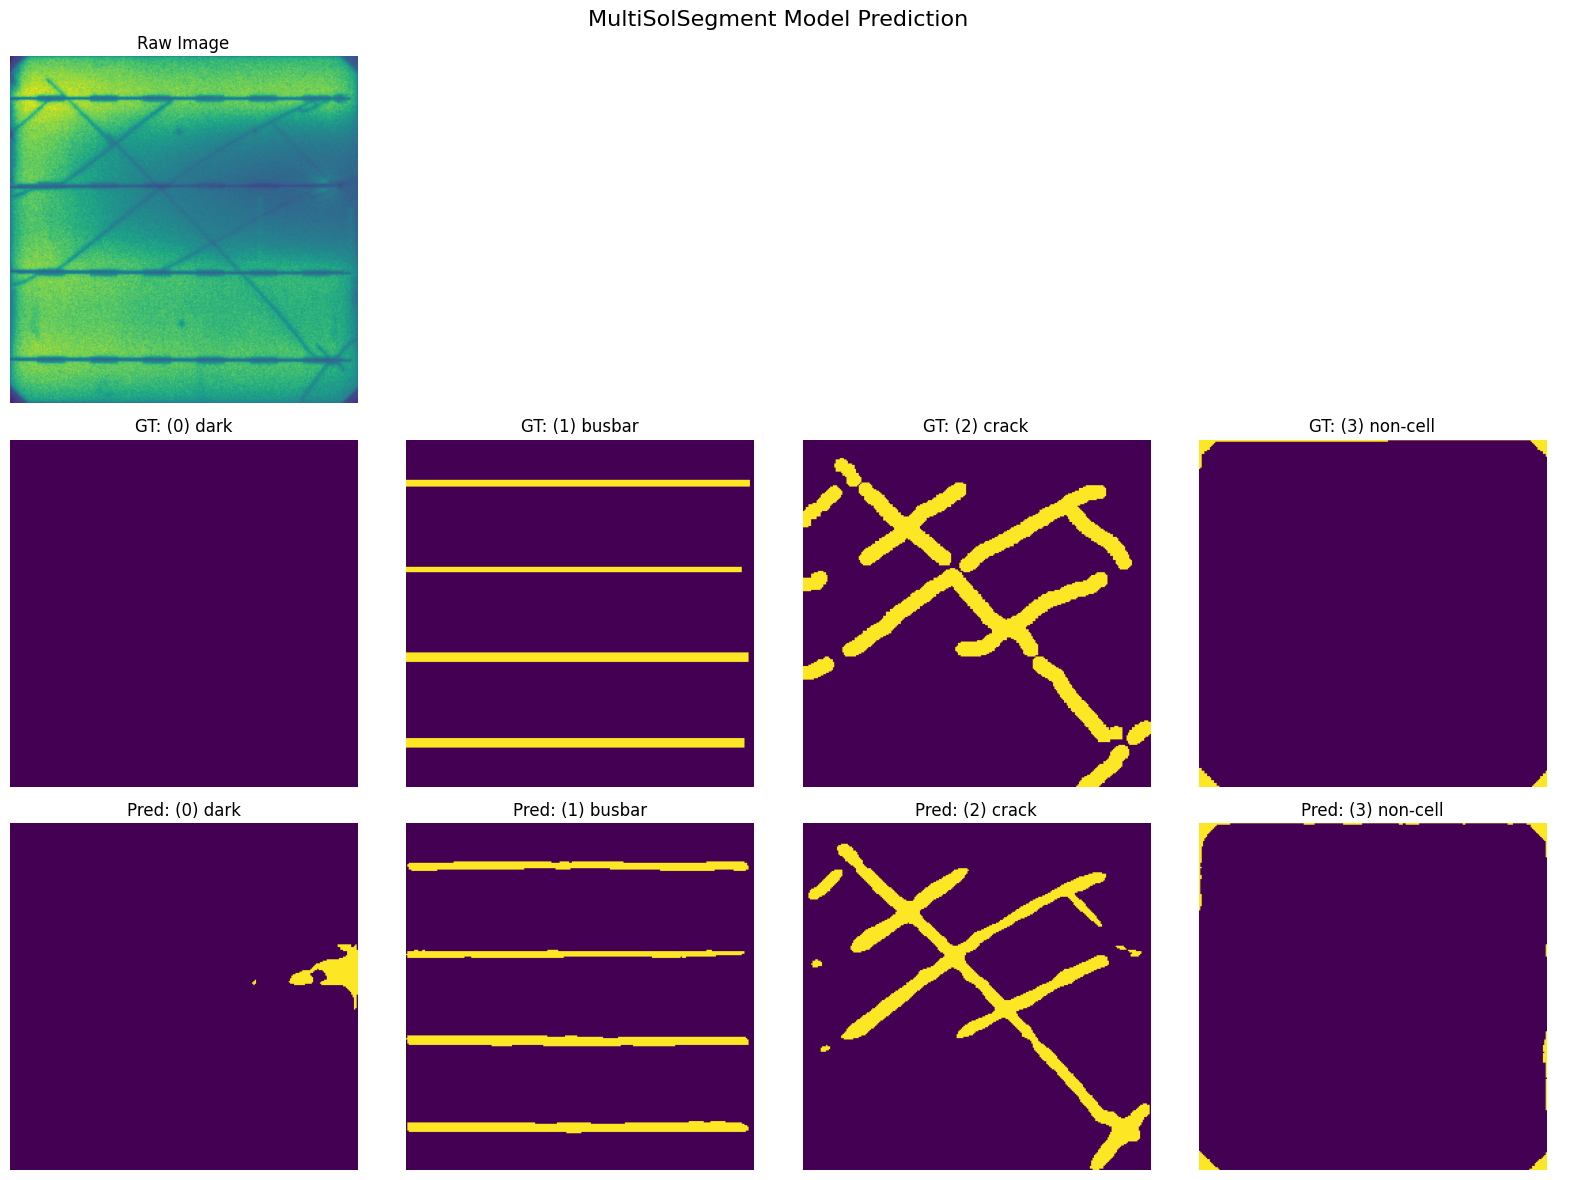

Id:  164


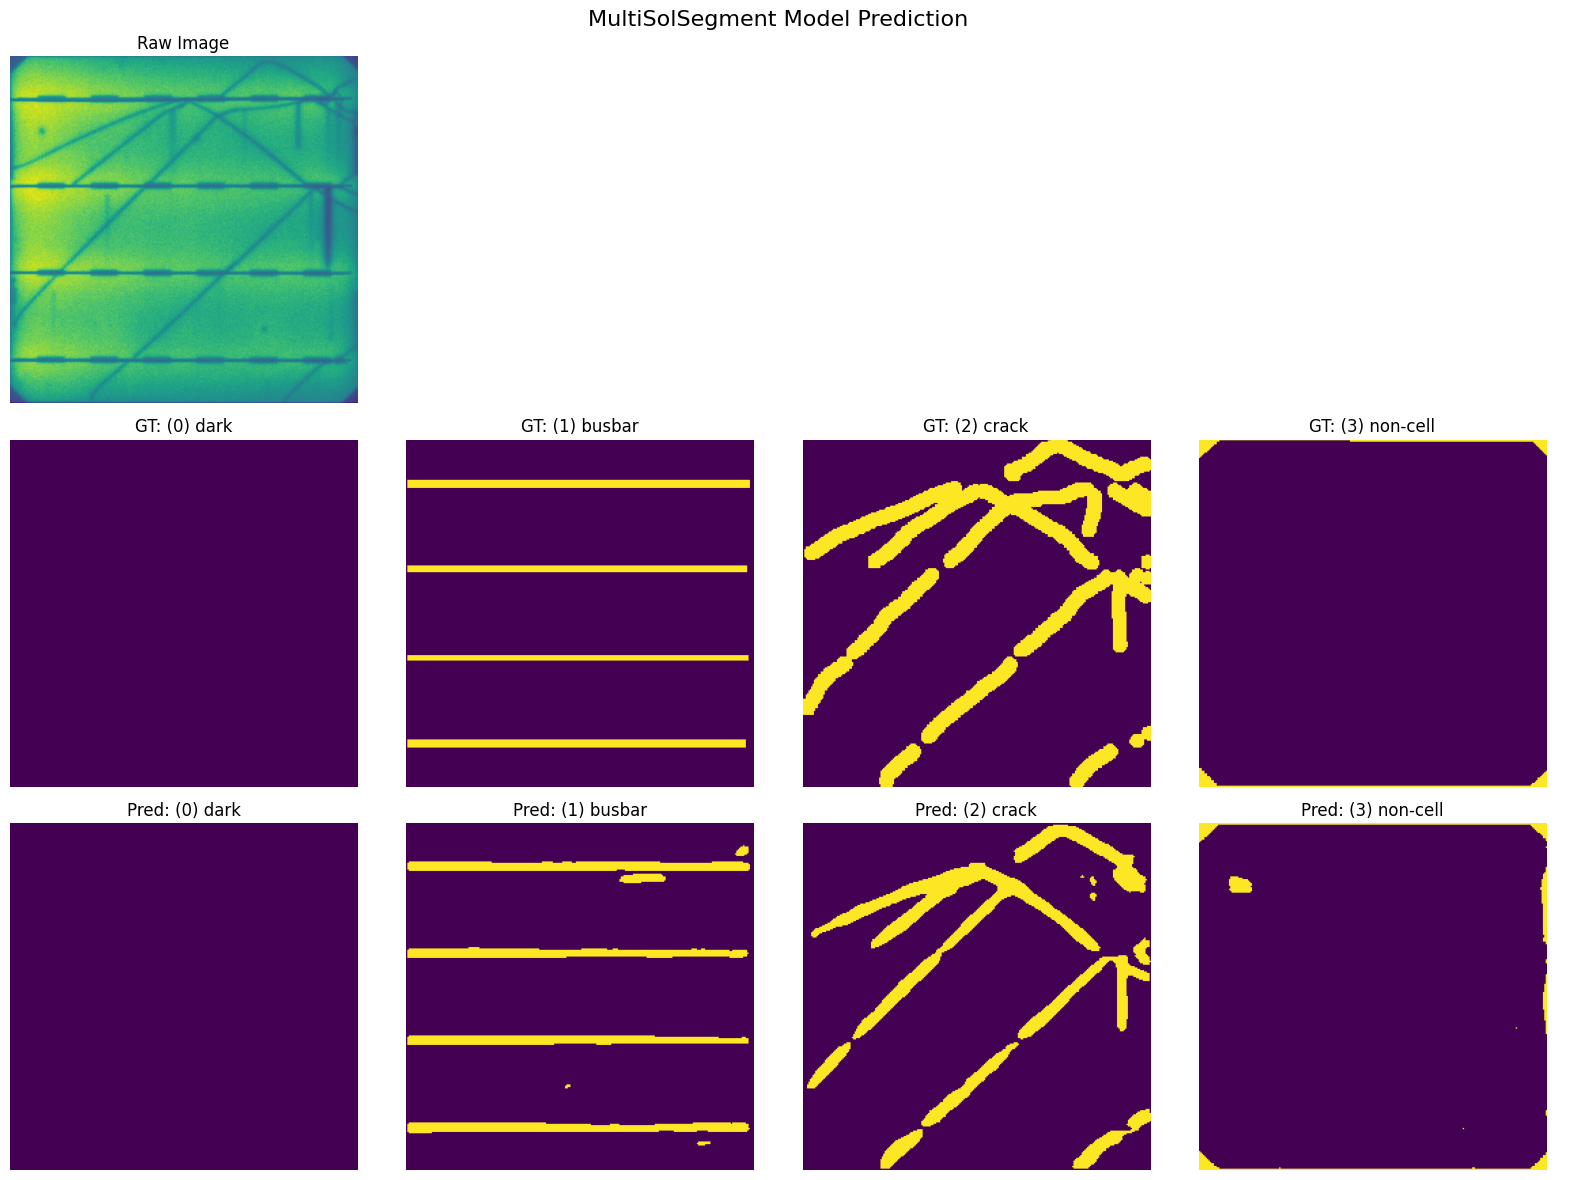

Id:  167


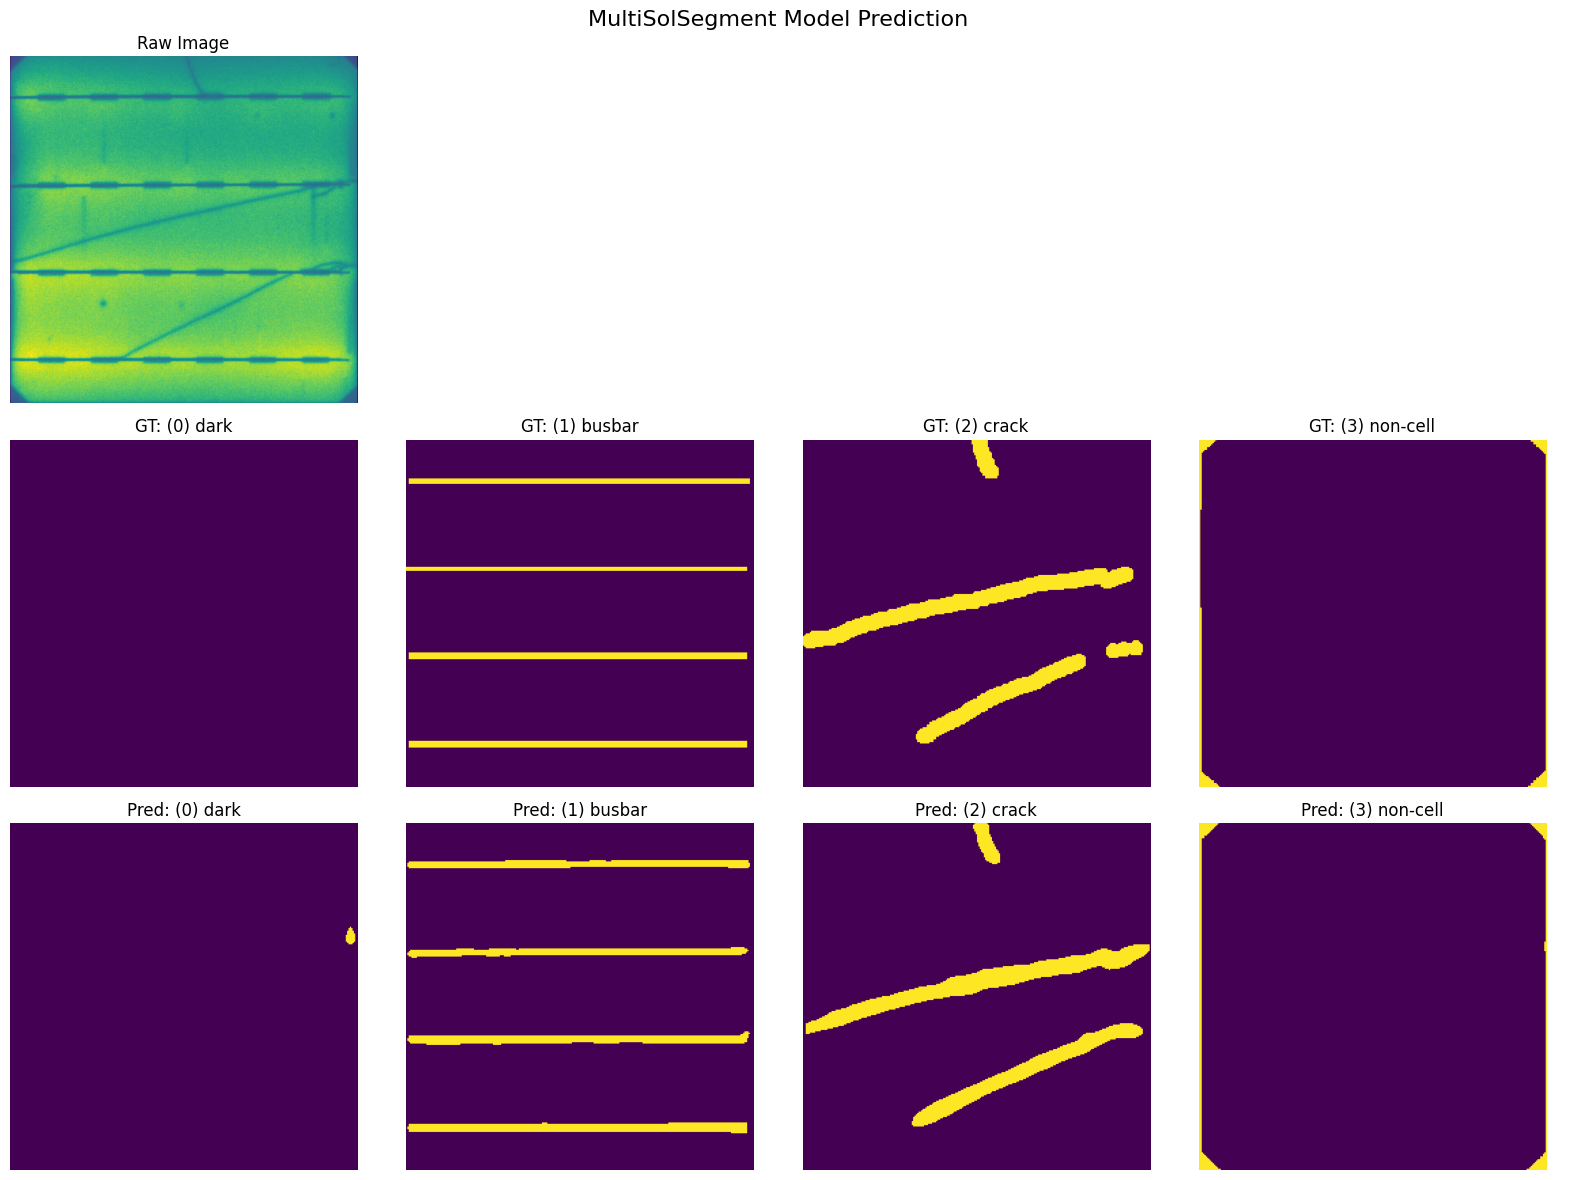

Id:  171


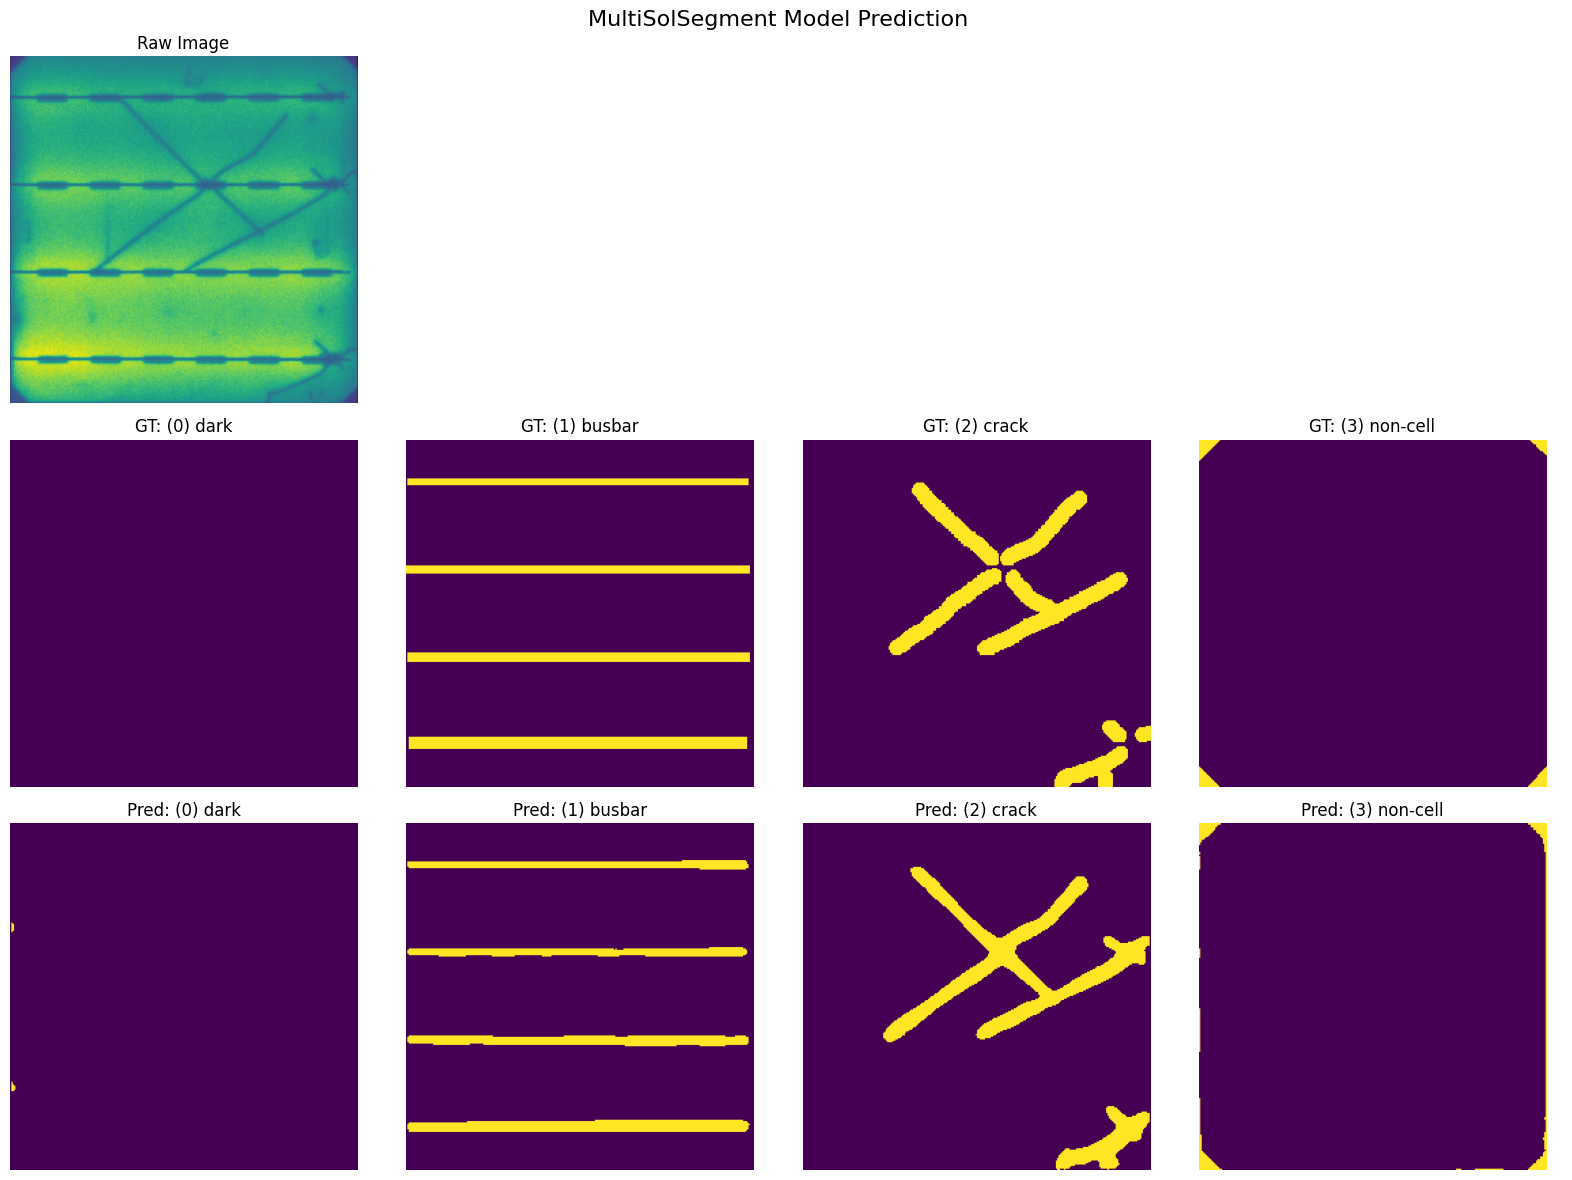

Id:  193


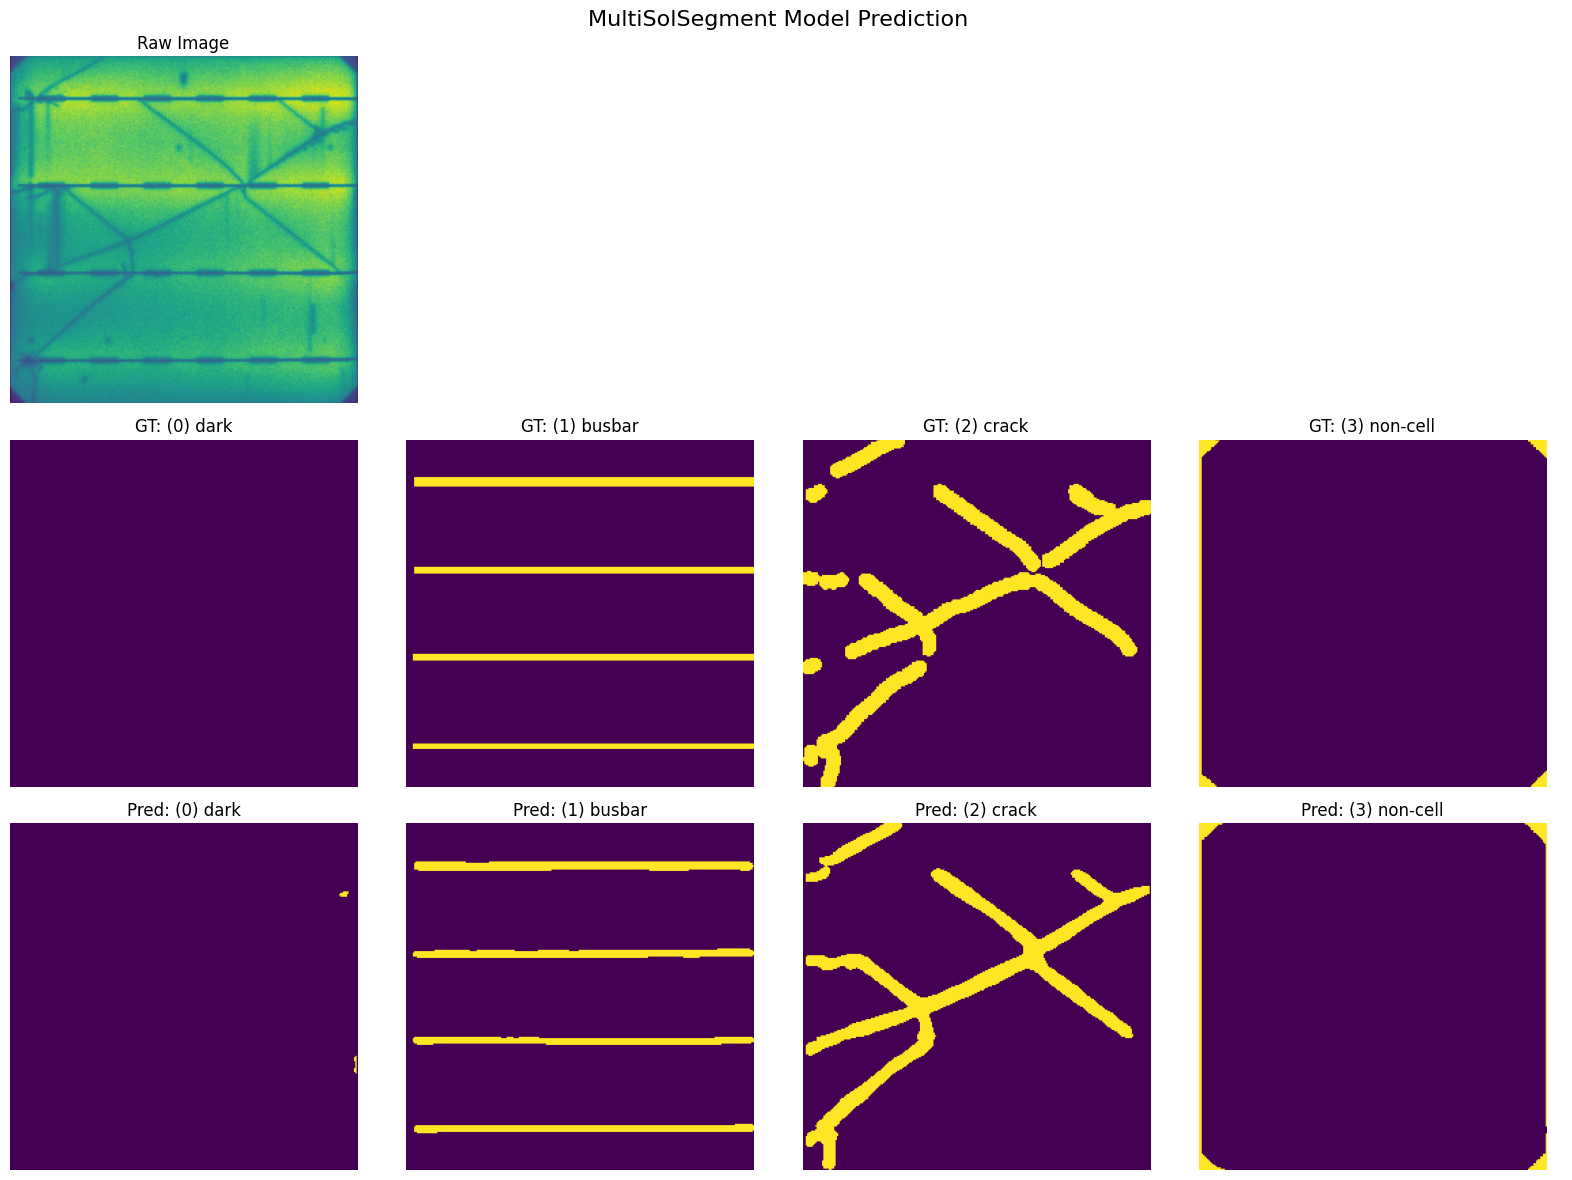

Id:  199


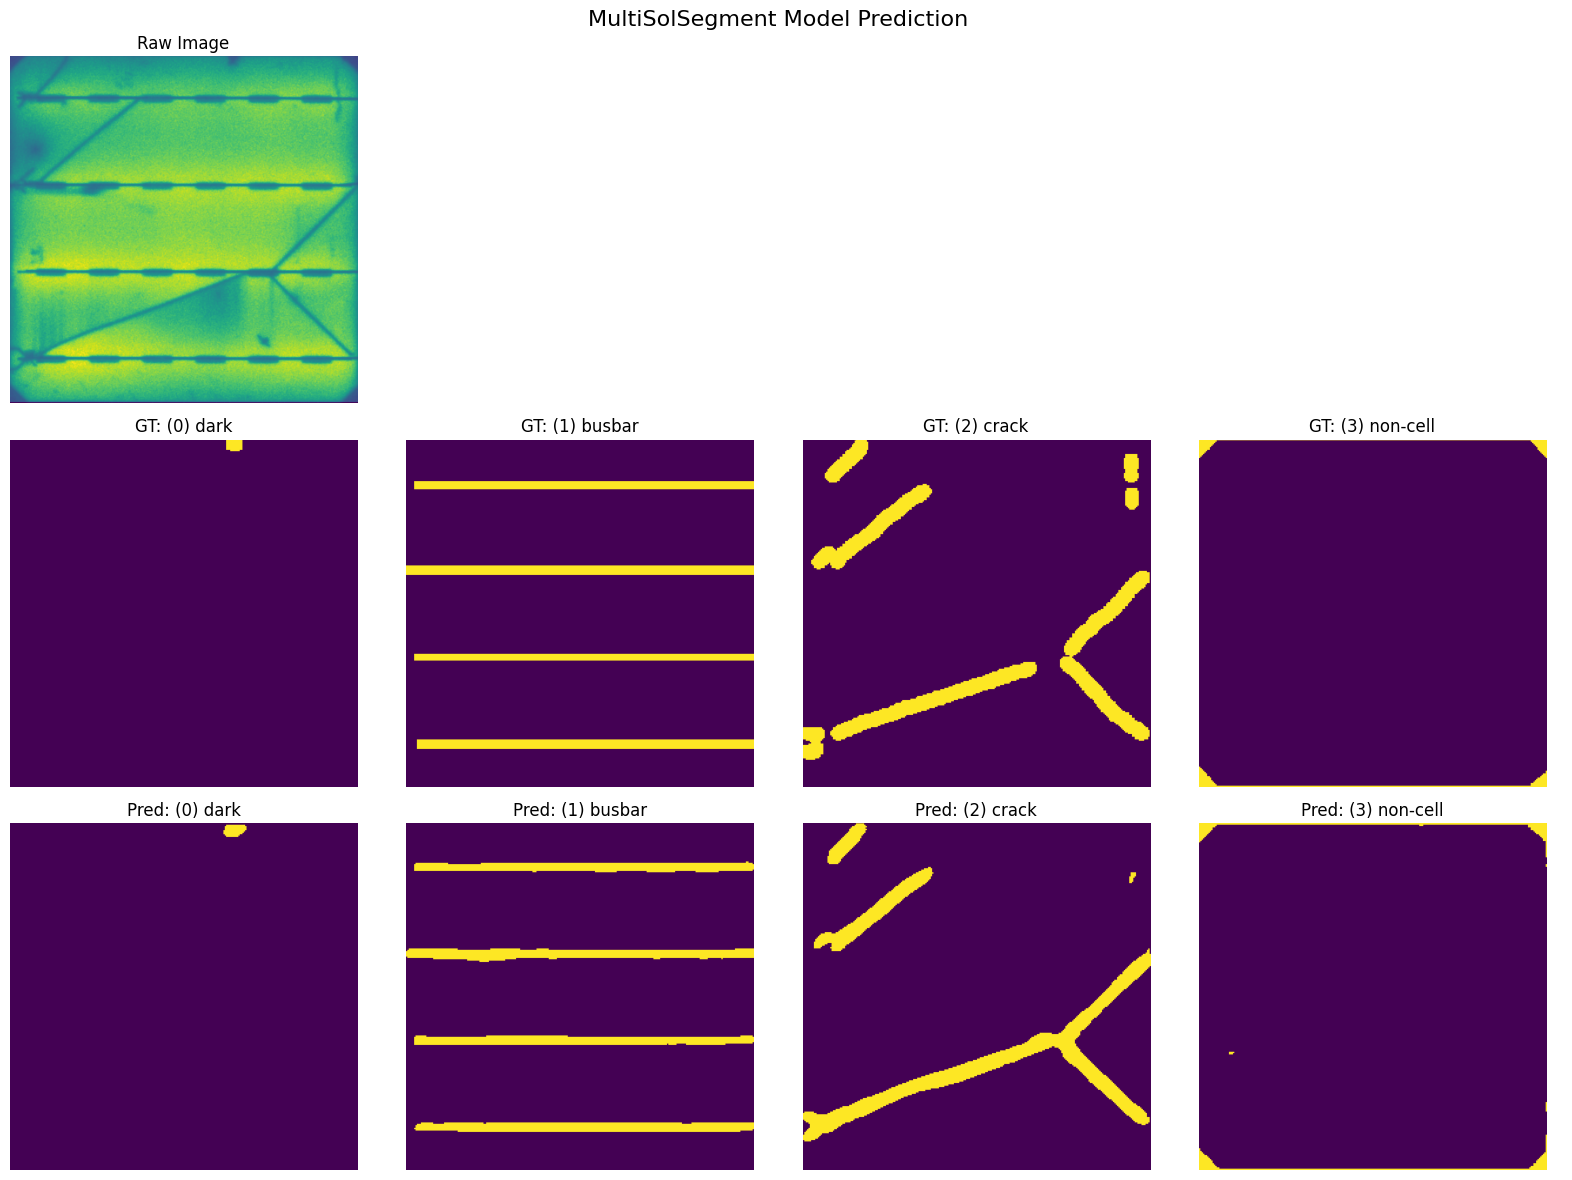

Id:  246


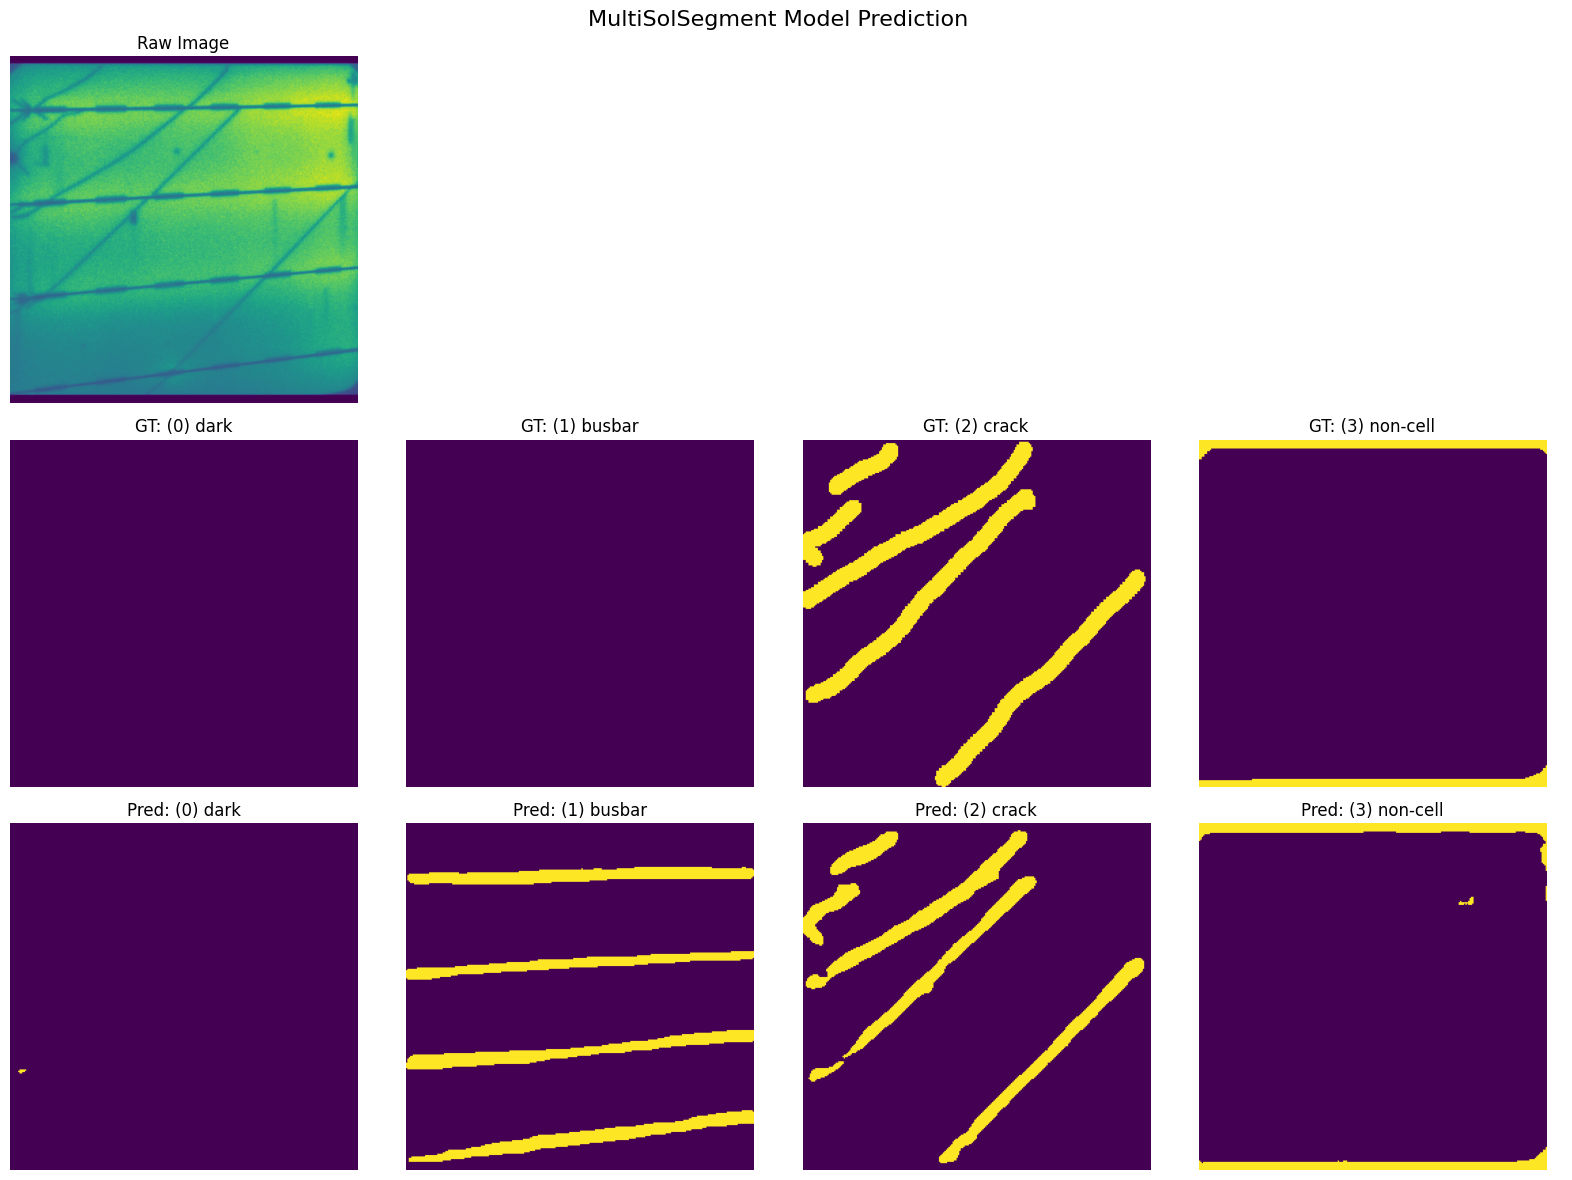

Id:  265


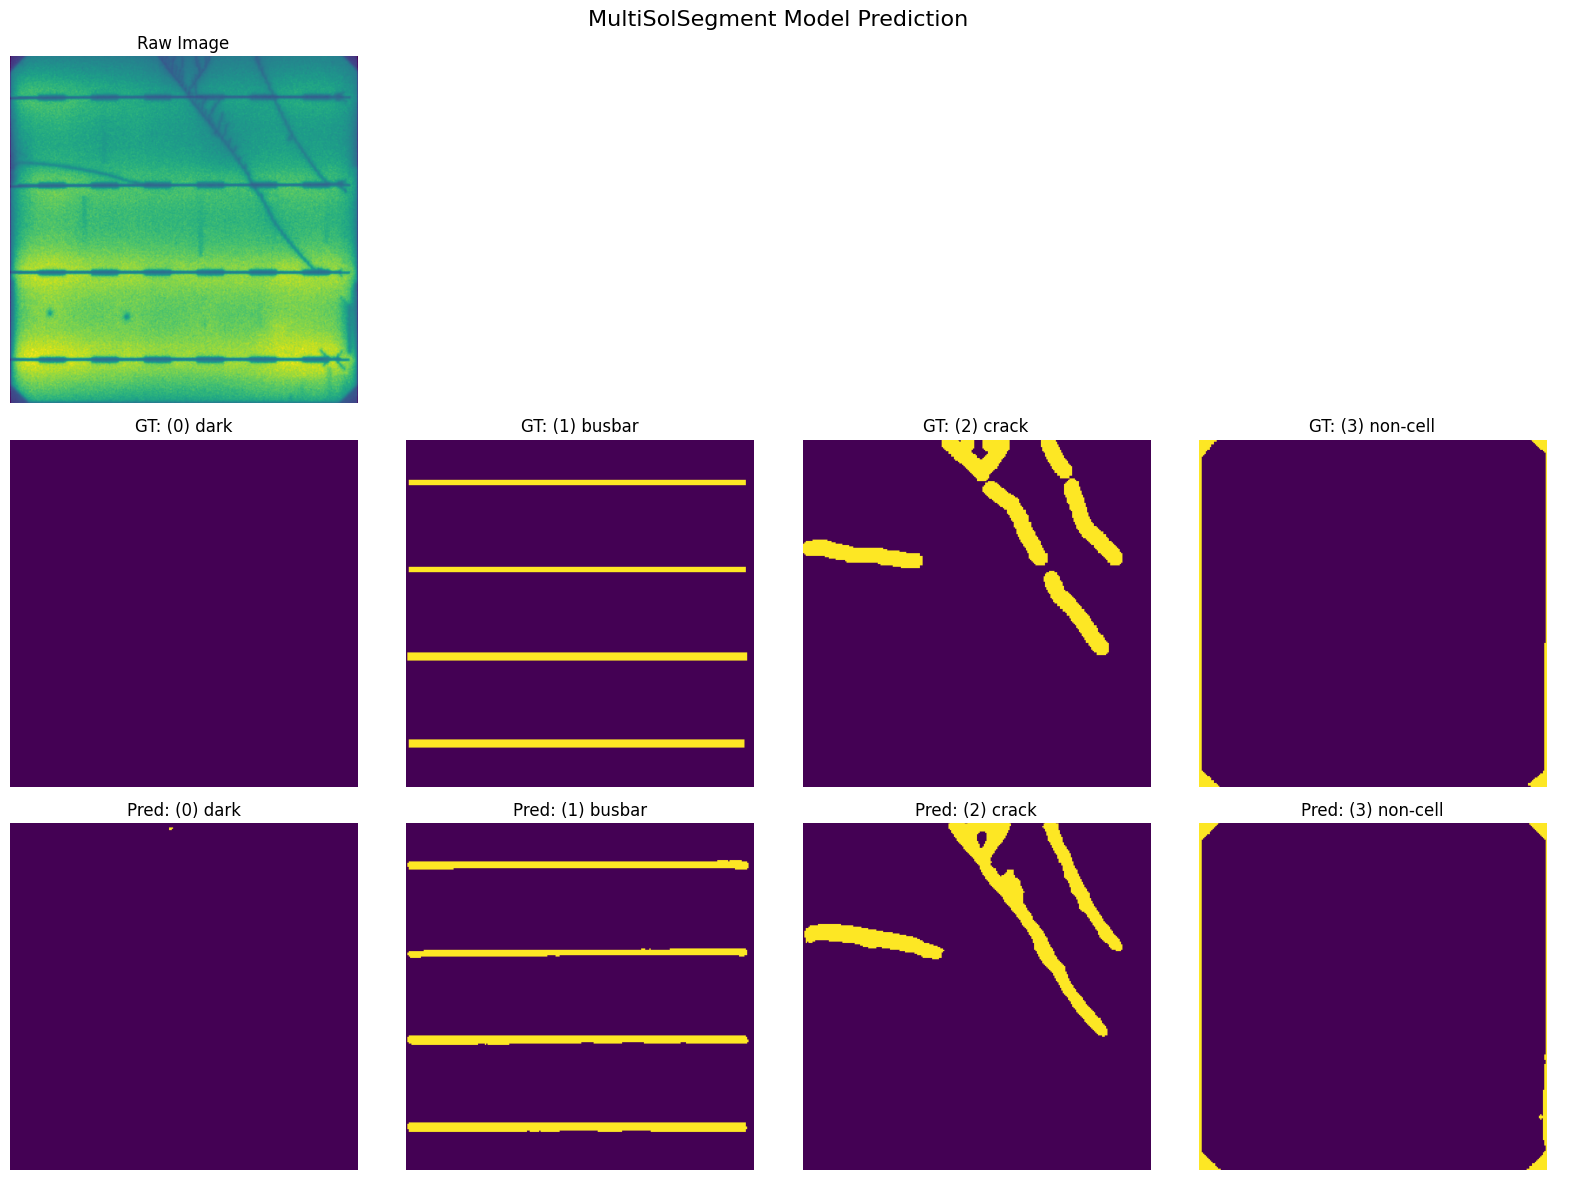

In [13]:
for i in [22, 34, 42, 53, 59, 84, 95, 98, 99, 107, 117, 129, 138, 152, 157, 164, 167, 171, 193, 199, 246, 265]:
# for i in range(200, 300):
    print("Id: ", i)
    viz_functions.channeled_inference_and_show(
        val_loader,
        device,
        model,
        category_mapping,
        i,
        threshold,
        custom_title="MultiSolSegment Model Prediction",
    )

## Step 7: Investigate dark area %

In [14]:
def channel_activation_percentages(mask, category_mapping):
    """
    Calculate the percentage of pixels activated for each channel in a multi-hot mask.

    Args:
        mask: 3D array-like of shape (n_channels, height, width) containing multi-hot activations.
        category_mapping (dict): Mapping from channel index to class name. The iteration order
            defines the channel order in the mask tensor.

    Returns:
        dict: Mapping from class name to percentage (0-100) of activated pixels in that channel.
    """

    mask_np = np.asarray(mask)

    if mask_np.ndim != 3:
        raise ValueError(
            f"Expected a 3D mask of shape (channels, height, width); got {mask_np.shape}."
        )

    n_channels, height, width = mask_np.shape
    total_pixels = height * width

    if total_pixels == 0:
        raise ValueError("Mask must contain at least one pixel.")

    percentages = {}
    for channel_idx, class_name in category_mapping.items():
        if channel_idx >= n_channels:
            raise ValueError(
                f"Channel index {channel_idx} for class '{class_name}' is out of bounds "
                f"for mask with {n_channels} channel(s)."
            )
        channel_activation = mask_np[channel_idx].sum()
        percentages[class_name] = (
            float(channel_activation) / float(total_pixels) * 100.0
        )

    return percentages


def print_channel_activation_percentages(percentages):
    print("Predicted channel activation (% of image):")
    sum = 0
    for _, class_name in category_mapping.items():
        print(f"\t{class_name}: {percentages[class_name]:.2f}%")
        sum += percentages[class_name]
    print("\tRemaining (solar cell): %.2f%%\n" % (100 - sum))

In [15]:
img, mask = val_dataset.__getitem__(idx)
img = img.to(device)
img_path = val_dataset.get_img_path(idx)

logits = model(img.unsqueeze(0)).detach().cpu()
probs = torch.sigmoid(logits)
pred_mask = (probs > threshold).float().squeeze(0).numpy()

gt_mask = mask.cpu().numpy()

gt_percentages = channel_activation_percentages(gt_mask, category_mapping)
pred_percentages = channel_activation_percentages(pred_mask, category_mapping)

print_channel_activation_percentages(gt_percentages)
print_channel_activation_percentages(pred_percentages)

Predicted channel activation (% of image):
	dark: 0.00%
	busbar: 6.87%
	crack: 12.53%
	non-cell: 2.00%
	Remaining (solar cell): 78.60%

Predicted channel activation (% of image):
	dark: 0.00%
	busbar: 8.09%
	crack: 11.27%
	non-cell: 2.55%
	Remaining (solar cell): 78.09%



## Step 8: Crack mask features with PVImage

Extract predicted crack masks, compute crack statistics with PVImage, and visualize the distribution of key metrics.


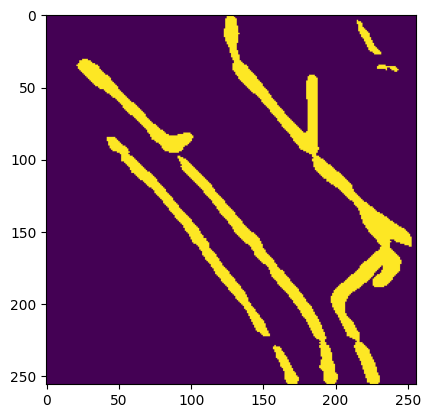

In [16]:
img, mask = val_dataset.__getitem__(idx)
img = img.to(device)
img_path = val_dataset.get_img_path(idx)

logits = model(img.unsqueeze(0)).detach().cpu()
probs = torch.sigmoid(logits)
pred_mask = (probs > threshold).float().squeeze(0).numpy()

fig, ax = plt.subplots()
ax.imshow(pred_mask[2], cmap="viridis")

In [17]:
crack_mask = (pred_mask[2] * 255).astype(np.uint8)  # Convert [0,1] to [0,255]

# Create DataFrame with image path
dfinfo = pd.DataFrame()
dfinfo["impath"] = [str(img_path)]  # Wrap in list

# Run feature extraction
dffeaturesreal = features.feature_extraction_crack_mask([crack_mask], dfinfo)
dffeaturesreal.head()

cell_number  i  prop.perimeter     slope  prop.convex_area  \
0  mx_sa19962_sub_EL_9  4      902.849855  0.813422           13731.0   
0  mx_sa19962_sub_EL_9  6      323.095454 -0.461515            2575.0   
0  mx_sa19962_sub_EL_9  3      200.526912  0.132013            1570.0   

   prop.area  prop.orientation  
0     5831.0           0.70676  
0     1857.0         -0.590016  
0     1120.0          0.216821

In [18]:
def violinplt(data, palette=None, figsize=(5, 4), y_axis_log=False):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Coerce to DataFrame so .mean() and column names behave
    if isinstance(data, pd.Series):
        data = data.to_frame()
    elif not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=figsize)

    # Seaborn API: no widths/showmeans/showmedians/showextrema here
    # Use inner="quartile" to show quartiles; cut=0 to avoid extrapolation
    sns.violinplot(
        data=data,
        ax=ax,
        palette=palette,
        inner="quartile",
        cut=0,
        linewidth=1,
    )

    # Overlay means as points
    means = data.mean().to_numpy()
    x_pos = np.arange(len(means))
    ax.scatter(x_pos, means, zorder=3)

    # Prepare mean labels
    nobs = [f"{m:.2f}" for m in means]

    # Place mean labels slightly above the point
    y_offset = 0.03 * (
        np.nanmax(means) - np.nanmin(means) if np.all(np.isfinite(means)) else 1.0
    )
    if len(x_pos) > 3:
        for i in x_pos:
            t = ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
                weight="semibold",
            )
            # subtle white box for readability
            t.set_bbox(
                dict(
                    facecolor="white",
                    alpha=0.5,
                    edgecolor="none",
                    boxstyle="round,pad=0.15",
                )
            )
        # Rotate tick labels cleanly
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    else:
        for i in x_pos:
            ax.text(
                i,
                means[i] + y_offset,
                nobs[i],
                ha="center",
                va="bottom",
                fontsize=12,
                color="black",
                weight="semibold",
            )

    ax.set_ylabel("Value")
    ax.set_xlabel("")
    if y_axis_log:
        ax.set_yscale("log")
    ax.margins(x=0.05)
    fig.tight_layout()
    return fig

In [19]:
dffeaturesreal["count_features"] = dffeaturesreal.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeaturesrealcount = dffeaturesreal.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)

In [20]:
dffeaturesrealcount.reset_index(drop=True, inplace=True)

featurescounted = pd.concat(
    [dffeaturesrealcount["count_features"]], axis=1, ignore_index=True
)
featurescounted.columns = ["Original"]
featurescounted.head()

Original
0         3

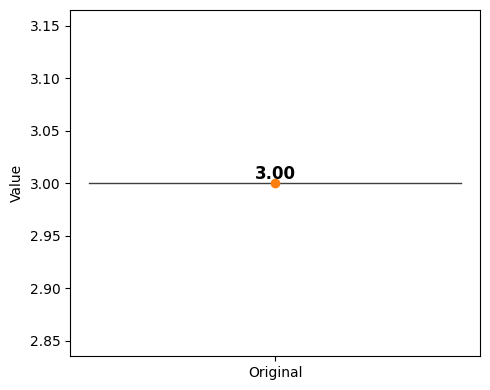

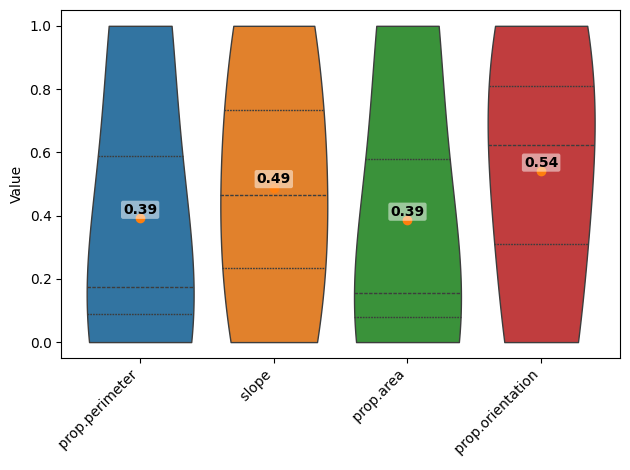

In [21]:
from sklearn.preprocessing import MinMaxScaler


dffeaturesall = dffeaturesreal


vp = violinplt(featurescounted[["Original"]], figsize=(5, 4))


scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeaturesall_norm = dffeaturesall[columnstonormalize]
dffeaturesall_norm[columnstonormalize] = scaler.fit_transform(dffeaturesall_norm)
fig = violinplt(
    dffeaturesall_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)
# fig.savefig("violins.png", bbox_inches="tight")

## Step 9: PVImage stats for many images

In [22]:
m_idx = len(val_dataset)  # indices to process
masks = []
impaths = []

for i in range(m_idx):
    img, _ = val_dataset.__getitem__(i)
    img = img.to(device)
    img_path = val_dataset.get_img_path(i)

    # model inference
    logits = model(img.unsqueeze(0)).detach().cpu()
    probs = torch.sigmoid(logits)
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # (n_classes, H, W)

    # Extract crack channel (index 2) and convert to uint8 [0,255]
    crack_mask = (pred_mask[2] * 255).astype(np.uint8)

    masks.append(crack_mask)
    impaths.append(str(img_path))

# Build dataframe of image paths expected by feature_extraction_crack_mask
dfinfo_multi = pd.DataFrame({"impath": impaths})

if os.path.exists("mms_dffeatures.pickle"):
    dffeatures_multi = pd.read_pickle("mms_dffeatures.pickle")
else:
    # Run PVImage feature extraction across all predicted crack masks
    dffeatures_multi = features.feature_extraction_crack_mask(masks, dfinfo_multi)
    dffeatures_multi["count_features"] = dffeatures_multi.groupby("cell_number")[
        "cell_number"
    ].transform("count")
    display(dffeatures_multi.head())
    dffeatures_multi.to_pickle("mms_dffeatures.pickle")


In [23]:
dffeatures_multi_count = dffeatures_multi.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
dffeatures_multi_count.reset_index(drop=True, inplace=True)

featurescounted_multi = pd.concat(
    [dffeatures_multi_count["count_features"]], axis=1, ignore_index=True
)
featurescounted_multi.columns = ["Original"]


# Show basic outputs
print(f"Processed {len(masks)} images, extracted {len(dffeatures_multi)} feature rows.")
display(featurescounted_multi.head())

Processed 468 images, extracted 605 feature rows.


Original
0         1
1         2
2         1
3         3
4         3

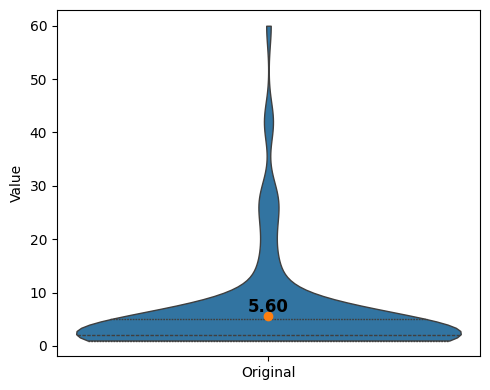

In [24]:
vp = violinplt(featurescounted_multi[["Original"]], figsize=(5, 4))

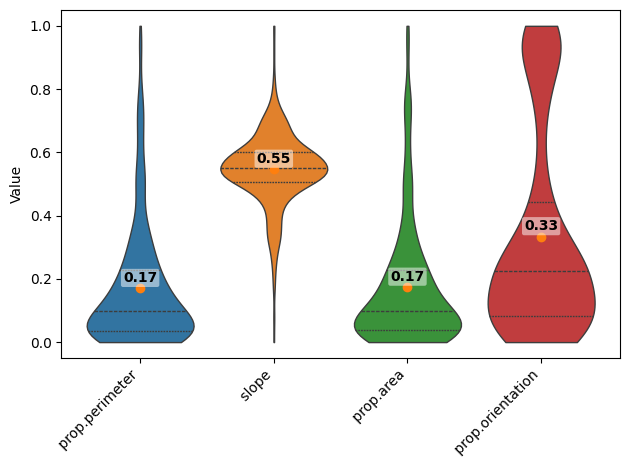

In [25]:
scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeatures_multi_norm = dffeatures_multi[columnstonormalize]
dffeatures_multi_norm[columnstonormalize] = scaler.fit_transform(dffeatures_multi_norm)
fig = violinplt(
    dffeatures_multi_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)

## Step 10: PVImage stats for ground truth crack masks

In [26]:
gt_masks = []
gt_impaths = []

for i in range(m_idx):
    _, gt_mask = val_dataset.__getitem__(i)
    img_path = val_dataset.get_img_path(i)

    crack_mask_gt = (gt_mask.cpu().numpy()[2] * 255).astype(np.uint8)

    gt_masks.append(crack_mask_gt)
    gt_impaths.append(str(img_path))

dfinfo_gt = pd.DataFrame({"impath": gt_impaths})
dffeatures_gt = features.feature_extraction_crack_mask(gt_masks, dfinfo_gt)


display(dffeatures_gt.head())

cell_number  i  prop.perimeter     slope  prop.convex_area  \
0   mx_sa19978_sub_EL_9  3      568.818326 -0.823008            5681.0   
0   mx_sa19978_sub_EL_9  1      184.526912  0.172644            1280.0   
0   mx_sa19971_sub_EL_9  0      102.727922 -0.036877             536.0   
0  mxy_sa19995_sub_EL_9  6       321.07821  -0.74215            3390.0   
0  mxy_sa19995_sub_EL_9  1      146.970563 -0.065422            1006.0   

   prop.area  prop.orientation  
0     3460.0         -0.762256  
0     1102.0          0.981023  
0      487.0         -0.041606  
0     2012.0         -0.715249  
0      746.0         -0.091053

In [27]:
dffeatures_gt["count_features"] = dffeatures_gt.groupby("cell_number")[
    "cell_number"
].transform("count")
dffeatures_gt_count = dffeatures_gt.sort_values(by="cell_number").drop_duplicates(
    "cell_number", keep="first"
)
dffeatures_gt_count.reset_index(drop=True, inplace=True)

featurescounted_gt = pd.concat(
    [dffeatures_gt_count["count_features"]], axis=1, ignore_index=True
)
featurescounted_gt.columns = ["Ground Truth"]

display(featurescounted_gt.head())
print(
    f"Processed {len(gt_masks)} ground-truth images, extracted {len(dffeatures_gt)} feature rows."
)

Ground Truth
0             3
1             2
2             3
3             4
4             6

Processed 468 ground-truth images, extracted 394 feature rows.


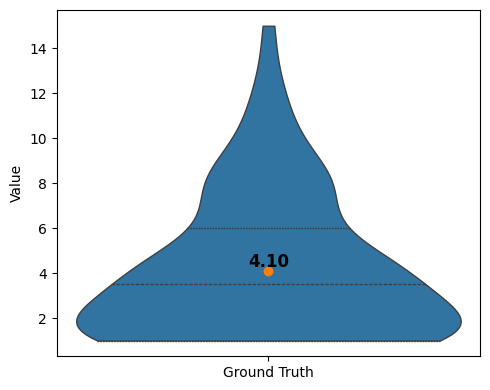

In [28]:
vp = violinplt(featurescounted_gt[["Ground Truth"]], figsize=(5, 4))


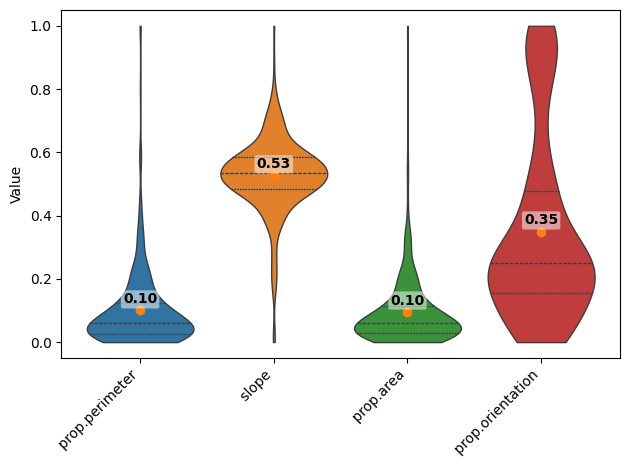

In [29]:
scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeatures_gt_norm = dffeatures_gt[columnstonormalize]
dffeatures_gt_norm[columnstonormalize] = scaler.fit_transform(dffeatures_gt_norm)
fig = violinplt(
    dffeatures_gt_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)

## Step 11: Compare PVImage stats (predicted vs. ground truth)

Join the PVImage outputs to see how the model's crack counts and shape metrics differ from the labeled data.


In [30]:
pred_counts = dffeatures_multi.groupby("cell_number").size().rename("pred_crack_count")
gt_counts = dffeatures_gt.groupby("cell_number").size().rename("gt_crack_count")

count_comparison = (
    pd.concat([pred_counts, gt_counts], axis=1).fillna(0).astype(int).reset_index()
)
count_comparison.columns = ["cell_number", "pred_crack_count", "gt_crack_count"]
count_comparison["count_diff"] = (
    count_comparison["pred_crack_count"] - count_comparison["gt_crack_count"]
)

display(count_comparison.head())


cell_number  pred_crack_count  gt_crack_count  count_diff
0             0563                 1               0           1
1             0774                 2               0           2
2             0809                 1               0           1
3  0_EL_18.09.2023                 3               0           3
4             1090                 3               0           3

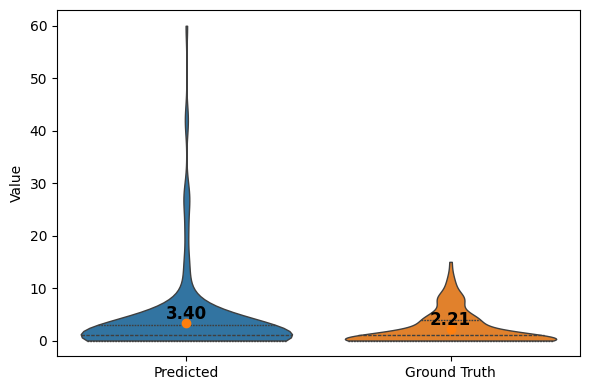

In [31]:
vp = violinplt(
    count_comparison[["pred_crack_count", "gt_crack_count"]].rename(
        columns={
            "pred_crack_count": "Predicted",
            "gt_crack_count": "Ground Truth",
        }
    ),
    figsize=(6, 4),
)


In [32]:
feature_cols = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
feature_comparison = pd.DataFrame(
    {
        "Predicted_mean": dffeatures_multi_norm[feature_cols].mean(),
        "GroundTruth_mean": dffeatures_gt_norm[feature_cols].mean(),
    }
)
feature_comparison["abs_diff"] = (
    feature_comparison["Predicted_mean"] - feature_comparison["GroundTruth_mean"]
).abs()
feature_comparison


Predicted_mean  GroundTruth_mean  abs_diff
prop.perimeter          0.169469          0.099920  0.069549
slope                   0.546312          0.527057  0.019255
prop.area               0.173419          0.096446  0.076972
prop.orientation        0.333077          0.349504  0.016427

Predicted prop.perimeter  Ground Truth prop.perimeter  Predicted slope  \
0                    0.088642                     0.222535         0.583249   
1                    0.085913                     0.039839         0.595065   
2                    0.069831                     0.000951         0.485679   
3                    0.068796                     0.104757         0.649378   
4                    0.022900                     0.021984         0.717924   
..                        ...                          ...              ...   
600                  0.000147                          NaN         0.534953   
601                  0.138661                          NaN         0.521155   
602                  0.096036                          NaN         0.564823   
603                  0.100250                          NaN         0.589096   
604                  0.002677                          NaN         0.601269   

     Ground Truth slope  Predicted prop.area  Ground Truth prop.area  \
0              0.512852             0.082858                0.204291   
1              0.603495             0.075810                0.047175   
2              0.584420             0.067262                0.006197   
3              0.520213             0.077235                0.107809   
4              0.581821             0.025420                0.023454   
..                  ...                  ...                     ...   
600                 NaN             0.010048                     NaN   
601                 NaN             0.156569                     NaN   
602                 NaN             0.105354                     NaN   
603                 NaN             0.101530                     NaN   
604                 NaN             0.009748                     NaN   

     Predicted prop.orientation  Ground Truth prop.orientation  
0                      0.345031                       0.257264  
1                      0.376862                       0.812402  
2                      0.055706                       0.486751  
3                      0.735919                       0.272233  
4                      0.981260                       0.471005  
..                          ...                            ...  
600                    0.201960                            NaN  
601                    0.232395                            NaN  
602                    0.284940                            NaN  
603                    0.058230                            NaN  
604                    0.019004                            NaN  

[605 rows x 8 columns]

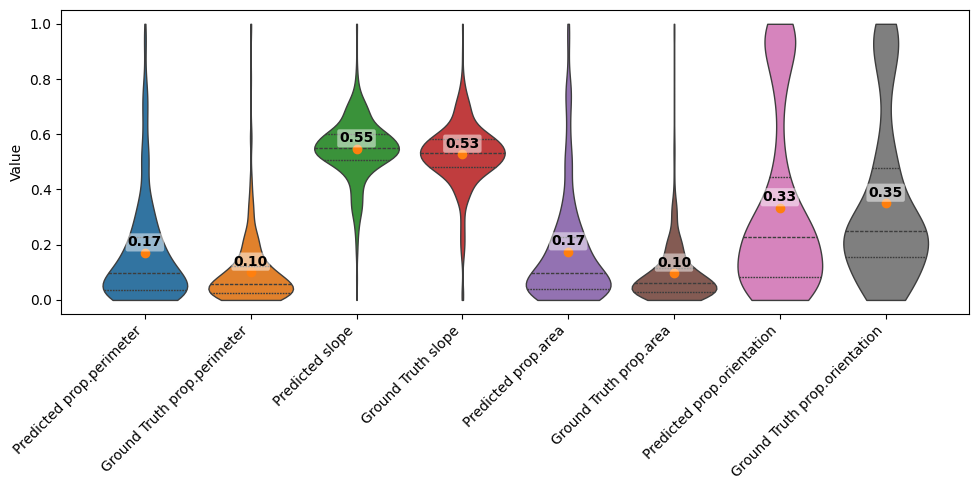

In [33]:
feature_pairs = []

for col in feature_cols:
    if (
        col not in dffeatures_multi_norm.columns
        or col not in dffeatures_gt_norm.columns
    ):
        print(f"Skipping {col}: not found in features dataframe.")
        continue

    label = col.strip()
    pred = dffeatures_multi_norm[col].reset_index(drop=True)
    gt = dffeatures_gt_norm[col].reset_index(drop=True)

    max_len = max(len(pred), len(gt))
    if max_len == 0:
        print(f"Skipping {label}: no data to plot.")
        continue

    pred = pred.reindex(range(max_len))
    gt = gt.reindex(range(max_len))

    feature_pairs.append(
        pd.DataFrame(
            {
                f"Predicted {label}": pred,
                f"Ground Truth {label}": gt,
            }
        )
    )

if not feature_pairs:
    print("No feature data available for violin plots.")
    feature_violin_df = pd.DataFrame()
else:
    feature_violin_df = pd.concat(feature_pairs, axis=1)
    feature_violin_df = feature_violin_df.apply(pd.to_numeric, errors="coerce")
    feature_violin_df = feature_violin_df.dropna(axis=1, how="all")

    if feature_violin_df.empty:
        print("No numeric feature data available for violin plots.")
    else:
        # Render comparison violins
        vp = violinplt(feature_violin_df, figsize=(10, 5))

feature_violin_df


## Do same for pv-vision

In [34]:
# Load pv-vision model and weights
from torch.nn import DataParallel
from pvcracks.utils.unet_model import construct_unet

device = torch.device("mps")

# build & wrap
unet = construct_unet(5)
unet = DataParallel(unet)

# load the dict right out of the file — no prefixing
state_dict = torch.load(
    "unet_oversample_low_final_model_for_paper/model.pt", map_location=device
)

unet.load_state_dict(state_dict)
model_pvvision = unet.module.to(device)

In [35]:
category_mapping = {
    0: "dark",
    1: "busbar",
    2: "crack",
    3: "cross",
}  # I think this is the third category "x-cracks"

threshold = 0.5  # default

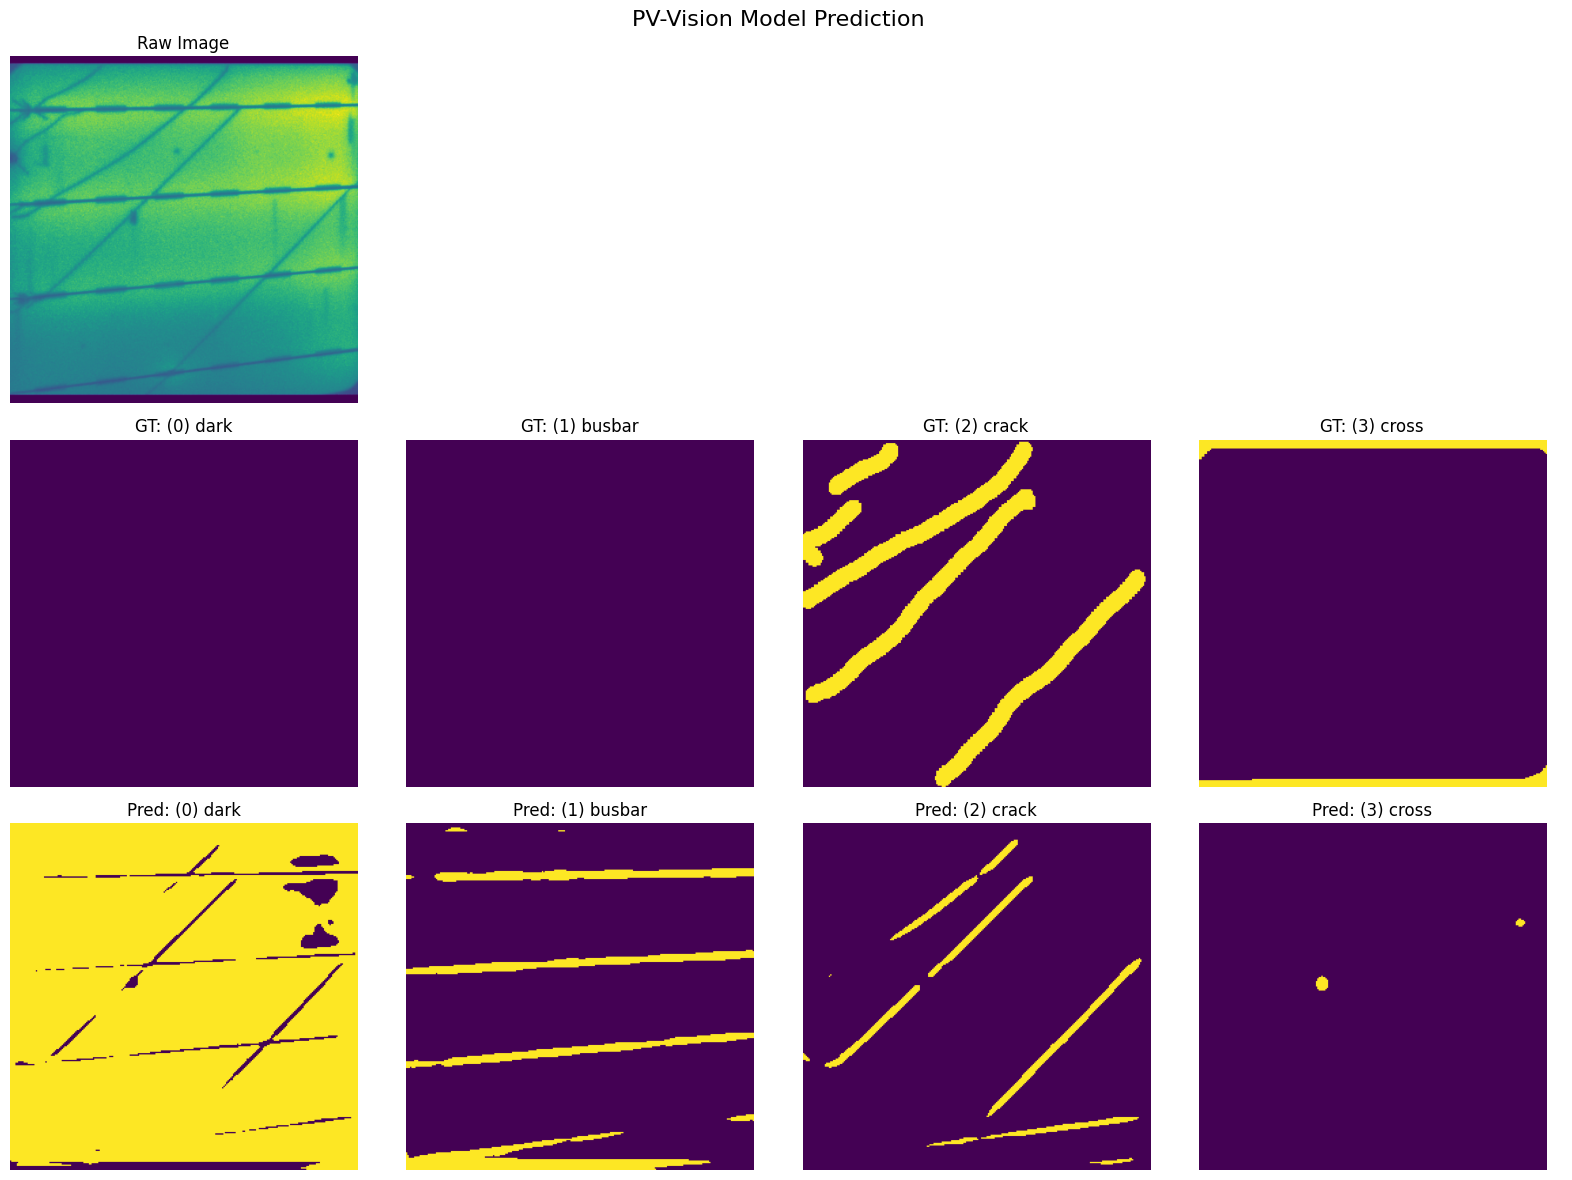

<Figure size 640x480 with 0 Axes>

In [36]:
idx = 246

viz_functions.channeled_inference_and_show(
    val_loader,
    device=device,
    model=model_pvvision,
    category_mapping=category_mapping,
    idx=idx,
    threshold=0.5,
    custom_title="PV-Vision Model Prediction",
)
plt.savefig("pvvision_model_prediction.png", dpi=300)

In [37]:
# All images
m_idx = len(val_dataset)  # indices to process
masks = []
impaths = []

for i in range(m_idx):
    img, _ = val_dataset.__getitem__(i)
    img = img.to(device)
    img_path = val_dataset.get_img_path(i)

    # model inference
    logits = model_pvvision(img.unsqueeze(0)).detach().cpu()
    probs = torch.sigmoid(logits)
    pred_mask = (probs > threshold).float().squeeze(0).numpy()  # (n_classes, H, W)

    # Extract crack channel (index 2) and convert to uint8 [0,255]
    crack_mask = (pred_mask[2] * 255).astype(np.uint8)

    masks.append(crack_mask)
    impaths.append(str(img_path))

# Build dataframe of image paths expected by feature_extraction_crack_mask
dfinfo_multi = pd.DataFrame({"impath": impaths})

if os.path.exists("pvvision_dffeatures.pickle"):
    dffeatures_multi_pvvision = pd.read_pickle("pvvision_dffeatures.pickle")
else:
    # Run PVImage feature extraction across all predicted crack masks
    dffeatures_multi_pvvision = features.feature_extraction_crack_mask(
        masks, dfinfo_multi
    )
    print(
        f"Processed {len(masks)} ground-truth images, extracted {len(dffeatures_multi)} feature rows."
    )
    display(dffeatures_multi_pvvision.head())

    dffeatures_multi_pvvision["count_features"] = dffeatures_multi_pvvision.groupby(
        "cell_number"
    )["cell_number"].transform("count")
    dffeatures_multi_pvvision.to_pickle("pvvision_dffeatures.pickle")


dffeatures_multi_count = dffeatures_multi_pvvision.sort_values(
    by="cell_number"
).drop_duplicates("cell_number", keep="first")
dffeatures_multi_count.reset_index(drop=True, inplace=True)

featurescounted_multi = pd.concat(
    [dffeatures_multi_count["count_features"]], axis=1, ignore_index=True
)
featurescounted_multi.columns = ["Original"]

# Show basic outputs
print(f"Processed {len(masks)} images, extracted {len(dffeatures_multi)} feature rows.")
display(featurescounted_multi.head())

Processed 468 images, extracted 605 feature rows.


Original
0         1
1         2
2         1
3         2
4         8

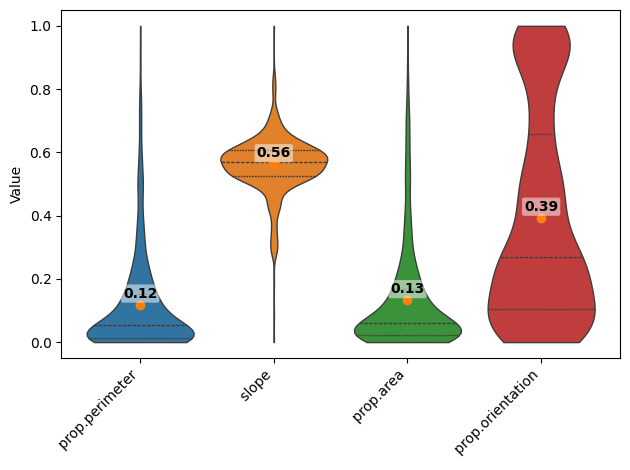

In [38]:
# Add ground truth
pred_counts = (
    dffeatures_multi_pvvision.groupby("cell_number").size().rename("pred_crack_count")
)
gt_counts = dffeatures_gt.groupby("cell_number").size().rename("gt_crack_count")

count_comparison = (
    pd.concat([pred_counts, gt_counts], axis=1).fillna(0).astype(int).reset_index()
)
count_comparison.columns = ["cell_number", "pred_crack_count", "gt_crack_count"]
count_comparison["count_diff"] = (
    count_comparison["pred_crack_count"] - count_comparison["gt_crack_count"]
)

scaler = MinMaxScaler()
columnstonormalize = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
dffeatures_multi_norm = dffeatures_multi_pvvision[columnstonormalize]
dffeatures_multi_norm[columnstonormalize] = scaler.fit_transform(dffeatures_multi_norm)
fig = violinplt(
    dffeatures_multi_norm[
        [
            " prop.perimeter",
            " slope",
            " prop.area",
            " prop.orientation",
        ]
    ],
    figsize=None,
)

Text(0.5, 1.0, 'pv-vision')

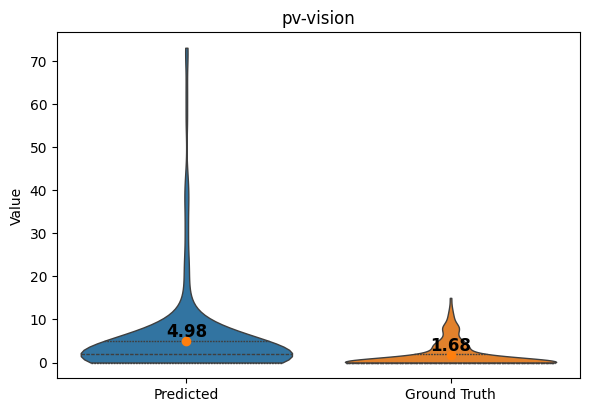

In [39]:
vp = violinplt(
    count_comparison[["pred_crack_count", "gt_crack_count"]].rename(
        columns={
            "pred_crack_count": "Predicted",
            "gt_crack_count": "Ground Truth",
        }
    ),
    figsize=(6, 4),
)
plt.title("pv-vision")

In [40]:
feature_cols = [
    " prop.perimeter",
    " slope",
    " prop.area",
    " prop.orientation",
]
feature_comparison = pd.DataFrame(
    {
        "Predicted_mean": dffeatures_multi_norm[feature_cols].mean(),
        "GroundTruth_mean": dffeatures_gt_norm[feature_cols].mean(),
    }
)
feature_comparison["abs_diff"] = (
    feature_comparison["Predicted_mean"] - feature_comparison["GroundTruth_mean"]
).abs()
feature_comparison


Predicted_mean  GroundTruth_mean  abs_diff
prop.perimeter          0.118078          0.099920  0.018158
slope                   0.561826          0.527057  0.034769
prop.area               0.131897          0.096446  0.035451
prop.orientation        0.392550          0.349504  0.043045

Predicted prop.perimeter  Ground Truth prop.perimeter  Predicted slope  \
0                     0.212781                     0.222535         0.551249   
1                     0.046023                     0.039839         0.556411   
2                     0.024984                     0.000951         0.513440   
3                     0.011955                     0.104757         0.643233   
4                     0.008581                     0.021984         0.682610   
...                        ...                          ...              ...   
1160                  0.015604                          NaN         0.603058   
1161                  0.013076                          NaN         0.590177   
1162                  0.010349                          NaN         0.600522   
1163                  0.125477                          NaN         0.597731   
1164                  0.001216                          NaN         0.592021   

      Ground Truth slope  Predicted prop.area  Ground Truth prop.area  \
0               0.512852             0.209742                0.204291   
1               0.603495             0.073433                0.047175   
2               0.584420             0.038487                0.006197   
3               0.520213             0.018442                0.107809   
4               0.581821             0.015569                0.023454   
...                  ...                  ...                     ...   
1160                 NaN             0.020313                     NaN   
1161                 NaN             0.023453                     NaN   
1162                 NaN             0.018241                     NaN   
1163                 NaN             0.173460                     NaN   
1164                 NaN             0.011426                     NaN   

      Predicted prop.orientation  Ground Truth prop.orientation  
0                       0.277283                       0.257264  
1                       0.282572                       0.812402  
2                       0.145407                       0.486751  
3                       0.920176                       0.272233  
4                       0.930895                       0.471005  
...                          ...                            ...  
1160                    0.999060                            NaN  
1161                    0.474024                            NaN  
1162                    0.531382                            NaN  
1163                    0.996901                            NaN  
1164                    0.003769                            NaN  

[1165 rows x 8 columns]

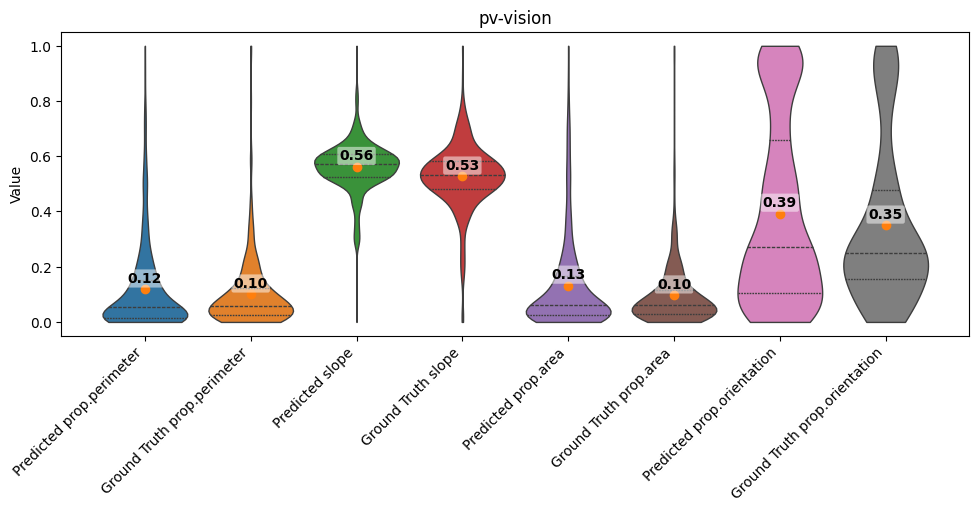

In [41]:
feature_pairs = []

for col in feature_cols:
    if (
        col not in dffeatures_multi_norm.columns
        or col not in dffeatures_gt_norm.columns
    ):
        print(f"Skipping {col}: not found in features dataframe.")
        continue

    label = col.strip()
    pred = dffeatures_multi_norm[col].reset_index(drop=True)
    gt = dffeatures_gt_norm[col].reset_index(drop=True)

    max_len = max(len(pred), len(gt))
    if max_len == 0:
        print(f"Skipping {label}: no data to plot.")
        continue

    pred = pred.reindex(range(max_len))
    gt = gt.reindex(range(max_len))

    feature_pairs.append(
        pd.DataFrame(
            {
                f"Predicted {label}": pred,
                f"Ground Truth {label}": gt,
            }
        )
    )

if not feature_pairs:
    print("No feature data available for violin plots.")
    feature_violin_df = pd.DataFrame()
else:
    feature_violin_df = pd.concat(feature_pairs, axis=1)
    feature_violin_df = feature_violin_df.apply(pd.to_numeric, errors="coerce")
    feature_violin_df = feature_violin_df.dropna(axis=1, how="all")

    if feature_violin_df.empty:
        print("No numeric feature data available for violin plots.")
    else:
        # Render comparison violins
        vp = violinplt(feature_violin_df, figsize=(10, 5))
        plt.title("pv-vision")

feature_violin_df


## Other Benchmarking metrics

In [42]:
# number of samples in the val set
m_idx = len(val_dataset)

# prepare lists to collect results
impaths = []
masks_multisolseg = []
masks_pvvision = []

for i in range(m_idx):
    # pull out the i-th sample and its path
    img, _ = val_dataset[i]
    img = img.to(device)
    img_path = val_dataset.get_img_path(i)

    impaths.append(str(img_path))

    # --- inference with multisolseg model ---
    with torch.no_grad():
        logits_ms = model(img.unsqueeze(0)).cpu()  # (1, n_classes, H, W)
        probs_ms = torch.sigmoid(logits_ms)  # same shape
        pred_ms = (probs_ms > threshold).float().squeeze(0).numpy()
    # extract crack channel #2, scale to [0,255]
    dark_ms = (pred_ms[0] * 255).astype(np.uint8)
    bb_ms = (pred_ms[1] * 255).astype(np.uint8)
    crack_ms = (pred_ms[2] * 255).astype(np.uint8)
    masks_multisolseg.append([dark_ms, bb_ms, crack_ms])

    # --- inference with pv-vision model ---
    with torch.no_grad():
        logits_pv = model_pvvision(img.unsqueeze(0)).cpu()
        probs_pv = torch.sigmoid(logits_pv)
        pred_pv = (probs_pv > threshold).float().squeeze(0).numpy()
    dark_pv = (pred_pv[0] * 255).astype(np.uint8)
    bb_pv = (pred_pv[1] * 255).astype(np.uint8)
    crack_pv = (pred_pv[2] * 255).astype(np.uint8)
    masks_pvvision.append([dark_pv, bb_pv, crack_pv])

In [43]:
# number of samples in the val set (same as before)
m_idx = len(val_dataset)

masks_gt = []
for i in range(m_idx):
    _, mask = val_dataset[i]
    mask_np = mask.cpu().numpy()  # → shape (n_classes, H, W)

    dark_gt = (mask_np[0] > 0).astype(np.uint8)  # bool→0/1→uint8
    bb_gt = (mask_np[1] > 0).astype(np.uint8)
    crack_gt = (mask_np[2] > 0).astype(np.uint8)

    masks_gt.append([dark_gt, bb_gt, crack_gt])

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# ----------------------------------------------------------------------------
# helper to compute IoU on two boolean masks
def compute_iou(gt: np.ndarray, pred: np.ndarray) -> float:
    inter = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    return float(inter) / union if union > 0 else 0.0


# class names and metric names
classes = ["dark", "busbar", "crack"]
metrics_names = ["Accuracy", "Precision", "Recall", "Dice", "IoU"]

# sanity‐check lengths
assert len(masks_gt) == len(masks_multisolseg) == len(masks_pvvision)
M = len(masks_gt)

# prepare accumulators
results_ms = {c: {m: [] for m in metrics_names} for c in classes}
results_pv = {c: {m: [] for m in metrics_names} for c in classes}

for gt_triplet, ms_triplet, pv_triplet in zip(
    masks_gt, masks_multisolseg, masks_pvvision
):
    for ci, cname in enumerate(classes):
        # boolean masks
        gt_mask = gt_triplet[ci] > 0  # shape (H,W)
        ms_mask = ms_triplet[ci] > 0
        pv_mask = pv_triplet[ci] > 0

        # flatten to vectors for sklearn
        y_true = gt_mask.flatten()
        y_ms = ms_mask.flatten()
        y_pv = pv_mask.flatten()

        # MultisolSegment metrics
        results_ms[cname]["Accuracy"].append(accuracy_score(y_true, y_ms))
        results_ms[cname]["Precision"].append(
            precision_score(y_true, y_ms, zero_division=0)
        )
        results_ms[cname]["Recall"].append(recall_score(y_true, y_ms, zero_division=0))
        results_ms[cname]["Dice"].append(f1_score(y_true, y_ms, zero_division=0))
        results_ms[cname]["IoU"].append(compute_iou(gt_mask, ms_mask))

        # PV-Vision metrics
        results_pv[cname]["Accuracy"].append(accuracy_score(y_true, y_pv))
        results_pv[cname]["Precision"].append(
            precision_score(y_true, y_pv, zero_division=0)
        )
        results_pv[cname]["Recall"].append(recall_score(y_true, y_pv, zero_division=0))
        results_pv[cname]["Dice"].append(f1_score(y_true, y_pv, zero_division=0))
        results_pv[cname]["IoU"].append(compute_iou(gt_mask, pv_mask))

n_classes = len(classes)
n_metrics = len(metrics_names)

avg_ms = np.zeros((n_classes, n_metrics), dtype=float)
avg_pv = np.zeros_like(avg_ms)

for ci, cname in enumerate(classes):
    for mi, mname in enumerate(metrics_names):
        avg_ms[ci, mi] = np.mean(results_ms[cname][mname])
        avg_pv[ci, mi] = np.mean(results_pv[cname][mname])

# --- ADDED: Overall (Macro Average) Calculation ---
overall_ms = np.mean(avg_ms, axis=0)
overall_pv = np.mean(avg_pv, axis=0)

# Extend classes list with 'Overall'
classes.append("Overall")
n_classes += 1

# Extend avg arrays to include Overall
avg_ms = np.vstack([avg_ms, overall_ms])
avg_pv = np.vstack([avg_pv, overall_pv])

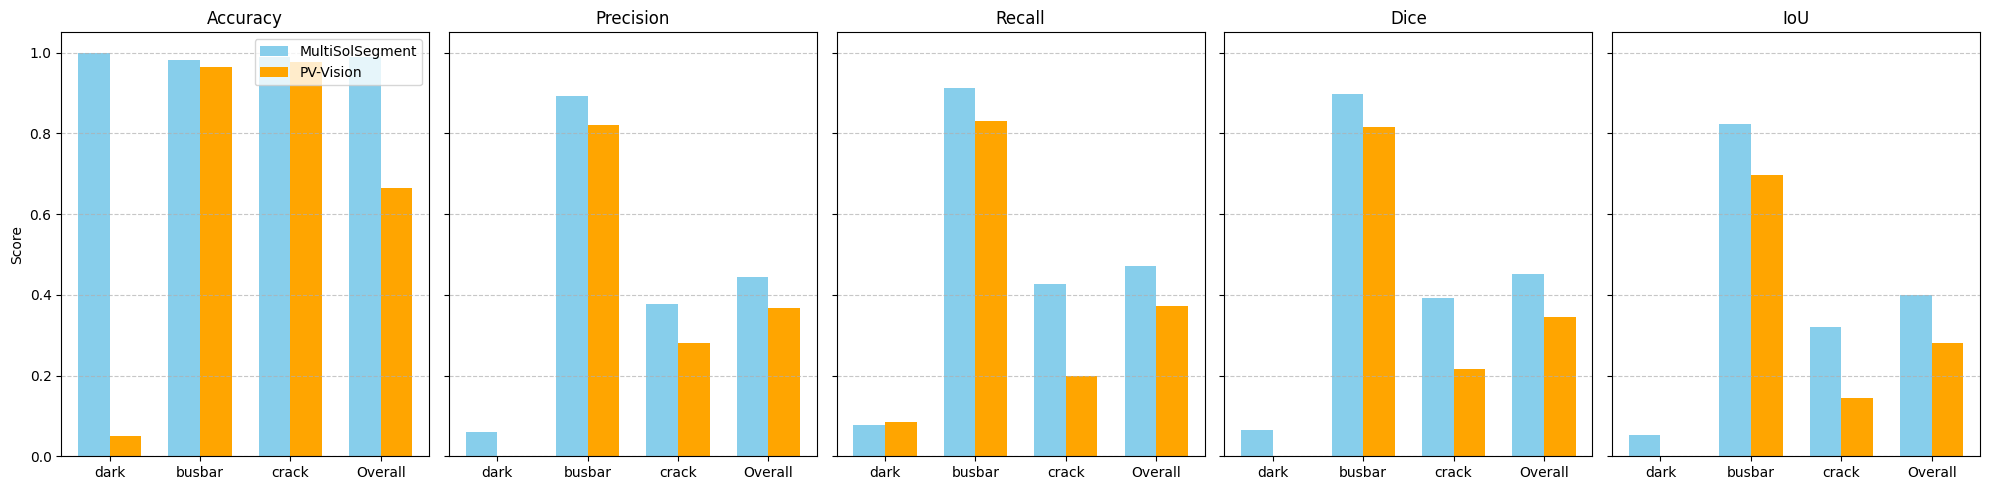

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
fig, axes = plt.subplots(1, n_metrics, figsize=(20, 5), sharey=True)
if n_metrics == 1:
    axes = [axes]

x = np.arange(n_classes)
width = 0.35

# Plot each metric in a separate subplot
for i, metric in enumerate(metrics_names):
    ax = axes[i]

    # Get values for this metric across all classes
    ms_values = avg_ms[:, i]
    pv_values = avg_pv[:, i]

    rects1 = ax.bar(
        x - width / 2, ms_values, width, label="MultiSolSegment", color="skyblue"
    )
    rects2 = ax.bar(x + width / 2, pv_values, width, label="PV-Vision", color="orange")

    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 1.05)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    if i == 0:
        ax.set_ylabel("Score")
        # Add legend only to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()

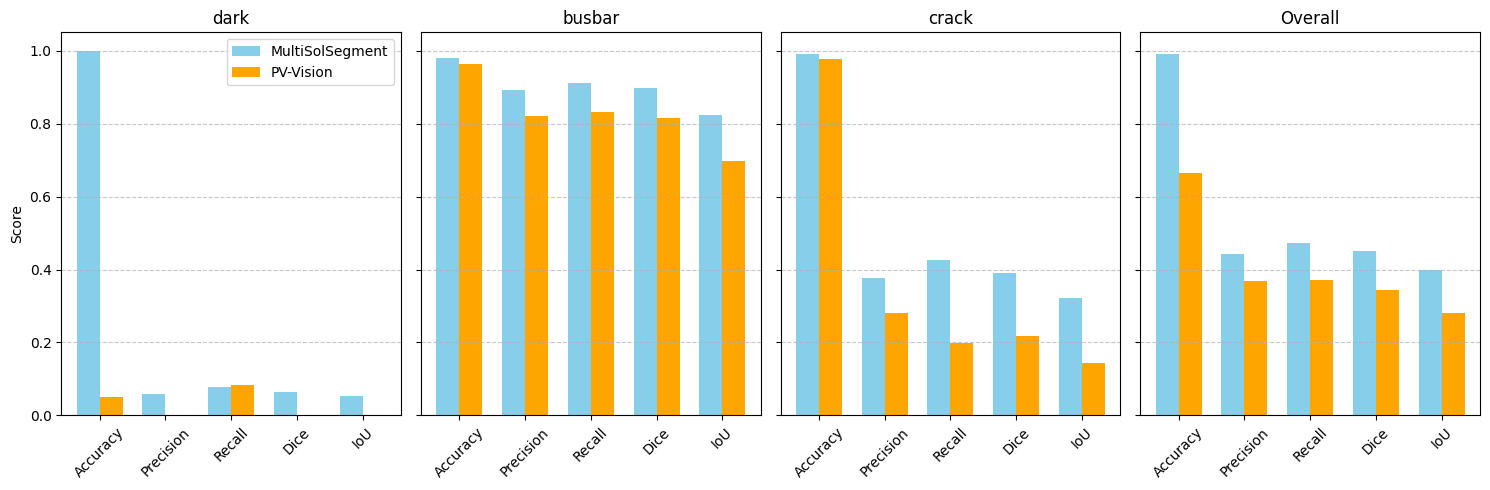

In [46]:
# New visualization: Subplots by Class
fig, axes = plt.subplots(1, n_classes, figsize=(15, 5), sharey=True)
if n_classes == 1:
    axes = [axes]

x = np.arange(n_metrics)
width = 0.35

for i, cname in enumerate(classes):
    ax = axes[i]

    # Get values for this class across all metrics
    # avg_ms shape is (n_classes, n_metrics)
    ms_values = avg_ms[i, :]
    pv_values = avg_pv[i, :]

    rects1 = ax.bar(
        x - width / 2, ms_values, width, label="MultiSolSegment", color="skyblue"
    )
    rects2 = ax.bar(x + width / 2, pv_values, width, label="PV-Vision", color="orange")

    ax.set_title(cname)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, rotation=45)
    ax.set_ylim(0, 1.05)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    if i == 0:
        ax.set_ylabel("Score")
        ax.legend()

plt.tight_layout()
plt.show()